# Data Wrangling and Cleaning
This notebook investigates the raw and partially processed datasets. 

# Table of Contents

- [Data Wrangling and Cleaning](#data-wrangling-and-cleaning)
- [Orders Dataset](#orders-dataset)
    - [Cleaning](#cleaning)
    - [Missing Values](#missing-values)
        - [Order, Item Name, and Item Variation](#order-item-name-and-item-variation)
        - [Item Modifiers](#item-modifiers)
        - [Recipient Email](#recipient-email)
    - [Correlations](#correlations)
        - [Channels and Fulfillment Type](#channels-and-fulfillment-type)
        - [Channels and Item Options Total Price](#channels-and-item-options-total-price)
    - [Outliers](#outliers)
        - [Postmates Item Total Price](#postmates-item-total-price)
        - [Payment Links Item Total Price](#payment-links-item-total-price)
        - [Belly Rubb Website Channels Item Total Price](#belly-rubb-website-channels-item-total-price)
    - [Imbalances](#imbalances)
        - [Fulfillment Status](#fulfillment-status)
    - [Zeros](#zeros)
- [Transactions Dataset](#transactions-dataset)
    - [Cleaning](#cleaning-1)
    - [Missing Values](#missing-values-1)
        - [Card and Deposit Columns](#card-and-deposit-columns)
          - [Investigate Fee Structure](#investigate-fee-structure)
        - [Customer ID, Name and Deposit, Fee](#customer-id-name-and-deposit-fee)

In [68]:
import os
import pandas as pd

# Data Visualization
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Helper functions
from belly_rubb_analysis.dataset import calculate_upper_bound

# Configuration info
%load_ext autoreload
%autoreload 1
%aimport belly_rubb_analysis.config
from belly_rubb_analysis.config import INTERIM_DATA_DIR, RAW_DATA_DIR, PROFILE_REPORTS_DIR, FIGURES_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# Enable scrolling
pd.set_option('display.max_columns', None)

# Orders Dataset

## Cleaning

Cleaning steps are refactored into "belly_rubb_analysis/dataset.py". These include:
    - Enforcing correct datatypes found in "docs/datatypes/".
    - Dropping columns with more than 70% missing values.
    - Dropping duplicate rows.
    - Dropping columns with a constant value.

In [70]:
orders_df = pd.read_csv(INTERIM_DATA_DIR / 'orders-2023-12-22-2024-12-20.csv')

orders_df.head()

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
0,Uber Eats Delivery A97C3,2024-12-20,48.99,4.65,53.64,2024-12-20 13:25:00,Pickup,Completed,Postmates Delivery,A97C3-Olga G.,NaN,+1 312-766-6835,1,BEEF BACK RIBS (Full Rack),Regular,1 x Signature BBQ Glaze,48.99,48.99,53.64
1,Uber Eats Delivery 86B6C,2024-12-19,40.12,3.81,43.93,2024-12-19 18:40:00,Pickup,Completed,Postmates Delivery,86B6C-Martin T.,NaN,+1 312-766-6835,1,LOADED FRIES,Regular,"1 x No Cheddar, 1 x No Provolone, 1 x Signatur...",11.99,22.18,24.29
2,Uber Eats Delivery 86B6C,2024-12-19,40.12,3.81,43.93,2024-12-19 18:40:00,Pickup,Completed,Postmates Delivery,86B6C-Martin T.,NaN,+1 312-766-6835,1,CHICKEN WINGS,6 pcs,1 x Sweet&Spicy glaze (Pairs well w/ LemonPeep...,17.94,17.94,19.64
3,Uber Eats Delivery 1B73A,2024-12-19,32.19,3.06,35.25,2024-12-19 14:59:00,Pickup,Completed,Postmates Delivery,1B73A-Diana O.,NaN,+1 312-766-6835,1,CIABATTA STEAK SANDWICH,Regular,NaN,19.45,19.45,21.30
4,Uber Eats Delivery 1B73A,2024-12-19,32.19,3.06,35.25,2024-12-19 14:59:00,Pickup,Completed,Postmates Delivery,1B73A-Diana O.,NaN,+1 312-766-6835,1,LOADED FRIES,Regular,"1 x Blue Cheese Sauce Drizzle, 1 x Salt and Pe...",11.99,12.74,13.95


In [71]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Order                     1413 non-null   object 
 1   Order Date                1414 non-null   object 
 2   Order Subtotal            1414 non-null   float64
 3   Order Tax Total           1414 non-null   float64
 4   Order Total               1414 non-null   float64
 5   Fulfillment Date          1414 non-null   object 
 6   Fulfillment Type          1414 non-null   object 
 7   Fulfillment Status        1414 non-null   object 
 8   Channels                  1414 non-null   object 
 9   Recipient Name            1414 non-null   object 
 10  Recipient Email           1073 non-null   object 
 11  Recipient Phone           1414 non-null   object 
 12  Item Quantity             1414 non-null   int64  
 13  Item Name                 1413 non-null   object 
 14  Item Var

## Missing Values

Although columns with more than 70% missing values were dropped, there are a few left with considerable missingness. These include:

    - `Recipient Email`: 23.8% missing
    - `Order`: 0.1% missing
    - `Item Name`: 0.1% missing
    - `Item Variation`: 0.1% missing
    - `Item Modifiers`: 40.5% missing

These will be investigated for any patterns.

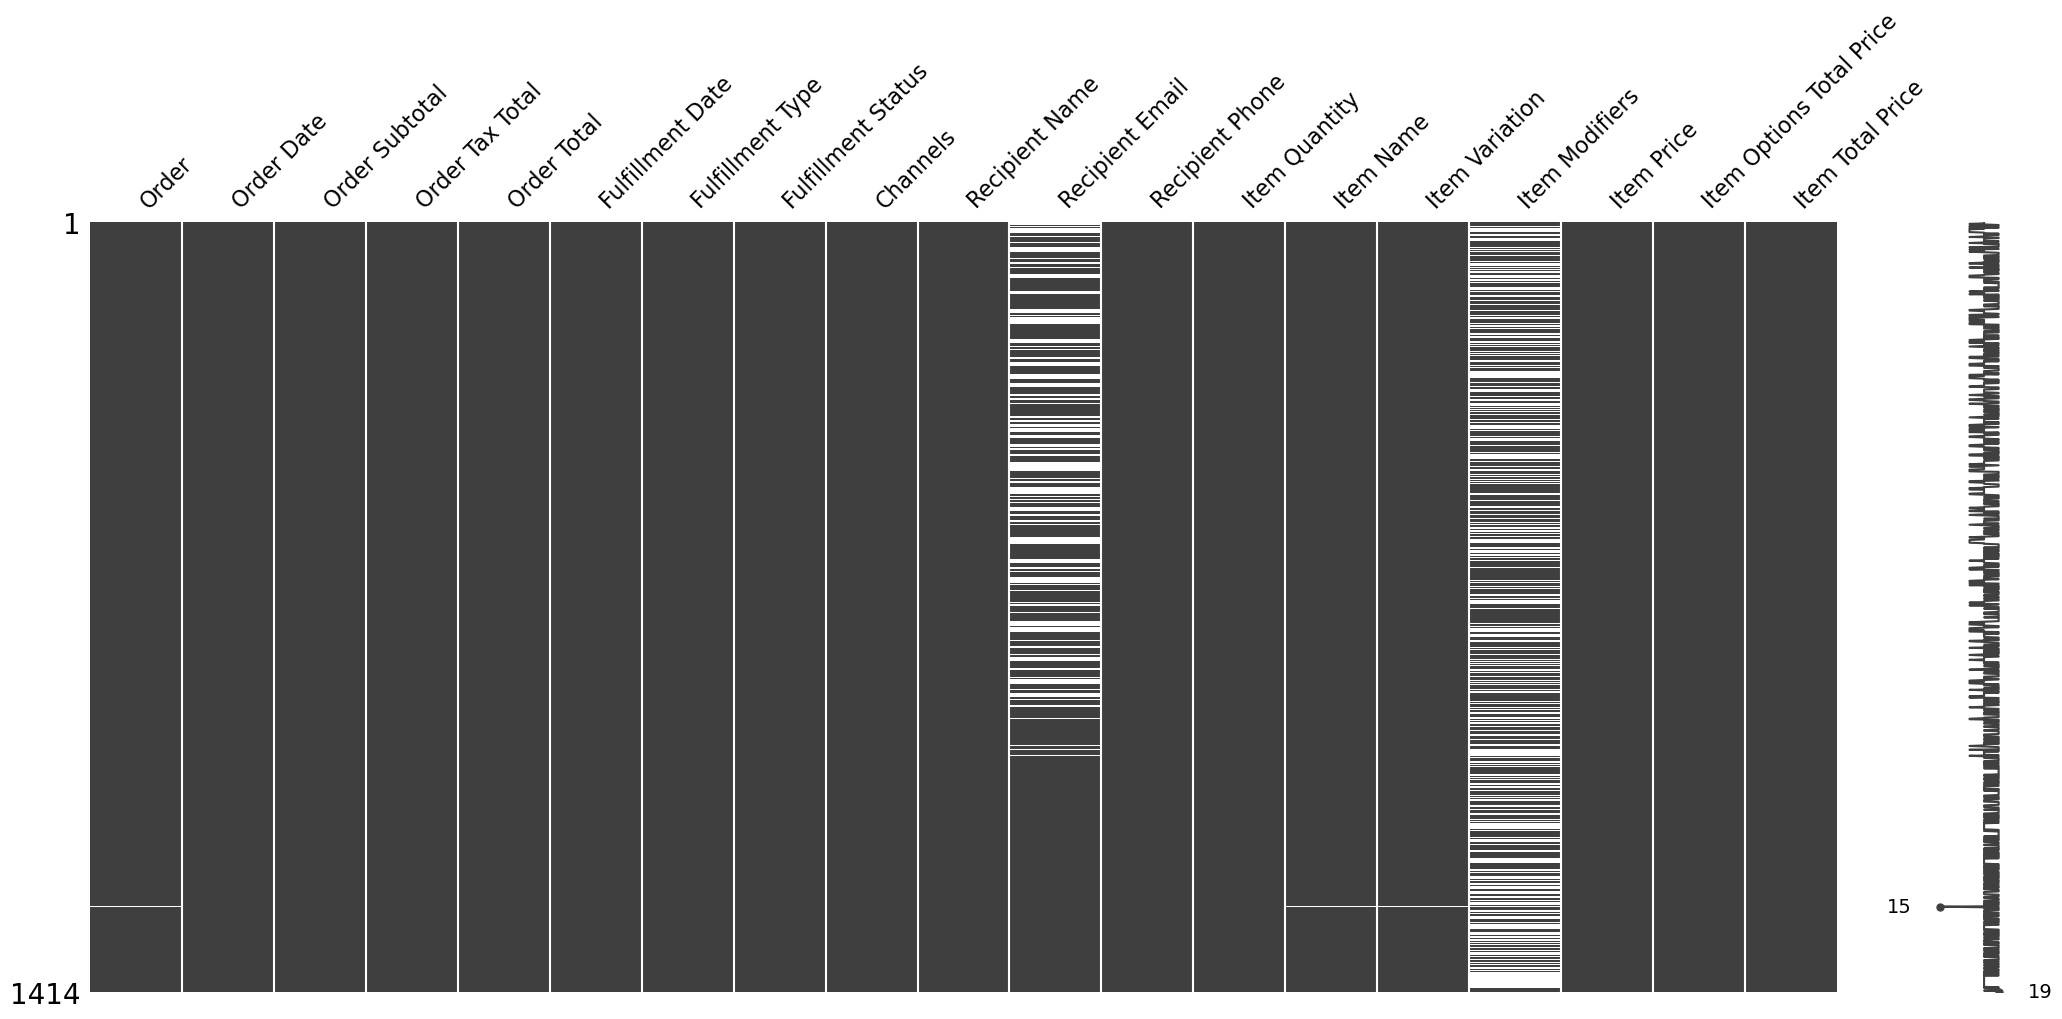

In [72]:
# Visualize missingness matrix

msno.matrix(orders_df)

plt.show()

### Order, Item Name, and Item Variation

There is one row which has missing values between Order, Item Name, Item Variation, and possibly Item Modifiers. We will investigate this row to understand the cause.

In [73]:
# Pull up single row with a missing value in Order

orders_df[orders_df['Order'].isna()]

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
1256,NaN,2024-03-07,450.0,42.75,512.75,2024-03-07 16:14:00,Other,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Levon Safaryan,bidium@gmail.com,+1 818-822-5060,1,NaN,NaN,NaN,450.0,450.0,492.75


Looks like this row is missing information about the items ordered as well. This could have been an order for a family member or friend, catering event, or cash which was entered into the system later.

### Item Modifiers

This column is missing 40.5% of its values. This is most likely due to the fact that this is an optional field for customers to enter personalized modifications when ordering. Just to be sure we'll see if there's a pattern to this missingness.

In [74]:
# Investigate values in Item Modifiers

orders_df['Item Modifiers'].unique()

array(['1 x Signature BBQ Glaze',
       '1 x No Cheddar, 1 x No Provolone, 1 x Signature BBQ Sauce Drizzle, 1 x Sweet and Spicy BBQ Sauce Dip, 1 x Lemon Pepper, 1 x Add Pork Rib Meat (Of-The-Bone!)',
       '1 x Sweet&Spicy glaze (Pairs well w/ LemonPeeper seasoning), 1 x Zesty Lemon Pepper',
       nan, '1 x Blue Cheese Sauce Drizzle, 1 x Salt and Pepper',
       '1 x Sweet&Spicy Glaze, 1 x Please, cut it!',
       '1 x Add gorgonzola! Make it special.',
       '1 x Please, cut it!, 1 x Signature BBQ Glaze',
       '1 x Signature BBQ Sauce Drizzle, 1 x Salt and Pepper',
       '1 x Lemon Pepper',
       '1 x Sprite ™, 1 x Mac & Cheese, 1 x Rosemary Pepper Fries, 1 x Sweet&Spicy Glaze, 1 x Boom-Boom Sauce DIp',
       '1 x Boom-Boom Sauce DIp, 1 x Sweet and Spicy BBQ Sauce Dip',
       '1 x Sweet and Spicy BBQ Sauce Dip, 1 x Pickled Jalapeño Peppers',
       '1 x Signature BBQ Glaze, 1 x Signature BBQ Sauce Dip',
       '1 x Rosemary Pepper',
       '1 x Salt&Pepper, 1 x Sweet&Spicy g

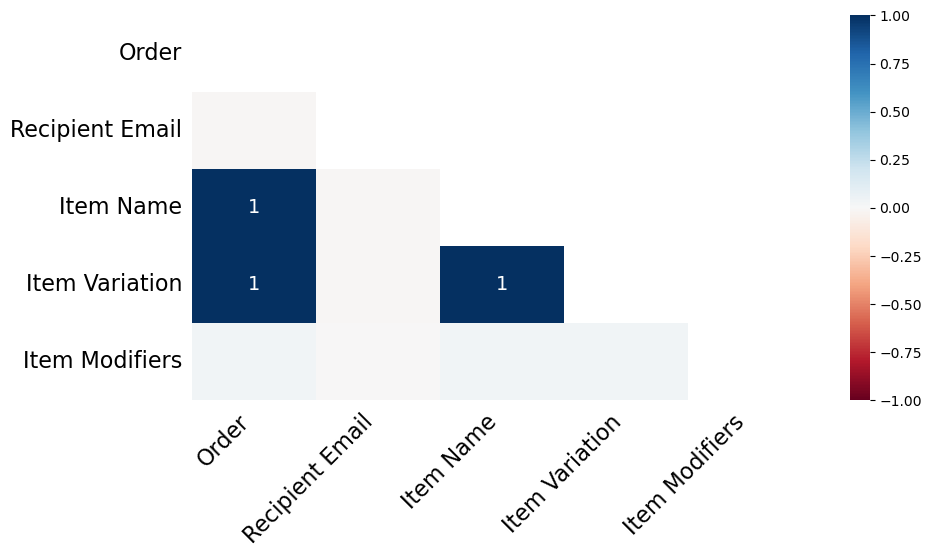

In [75]:
# Visualize missingness correlation

msno.heatmap(orders_df, figsize=(10,5))

plt.show()

The perfectly correlated features come from the single row which had all of those missing. Otherwise, there are no significant missingness correlations.

In [76]:
orders_df[orders_df['Item Modifiers'].isna()]

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
3,Uber Eats Delivery 1B73A,2024-12-19,32.19,3.06,35.25,2024-12-19 14:59:00,Pickup,Completed,Postmates Delivery,1B73A-Diana O.,NaN,+1 312-766-6835,1,CIABATTA STEAK SANDWICH,Regular,NaN,19.45,19.45,21.30
7,Postmates Delivery EAA45,2024-12-19,22.06,1.20,23.26,2024-12-19 11:26:00,Pickup,Completed,Postmates Delivery,EAA45-Anthony S.,NaN,+1 312-766-6835,1,PINEAPPLE SLAW,Full,NaN,9.46,9.46,9.46
8,Postmates Delivery EAA45,2024-12-19,22.06,1.20,23.26,2024-12-19 11:26:00,Pickup,Completed,Postmates Delivery,EAA45-Anthony S.,NaN,+1 312-766-6835,1,ARTISAN MAC AND CHEESE,Full,NaN,12.60,12.60,13.80
11,Uber Eats Delivery 8F819,2024-12-18,37.90,3.46,41.36,2024-12-18 13:58:00,Pickup,Completed,Postmates Delivery,8F819-Diana O.,NaN,+1 312-766-6835,1,CRISPY CHICKEN SANDWICH,Regular,NaN,16.46,16.46,18.02
13,Uber Eats Delivery 8F819,2024-12-18,37.90,3.46,41.36,2024-12-18 13:58:00,Pickup,Completed,Postmates Delivery,8F819-Diana O.,NaN,+1 312-766-6835,1,CREAMY BLUE CHEESE DIP,Regular,NaN,1.45,1.45,1.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,DOORDASH,2024-01-05,31.97,2.28,34.25,2024-01-05 15:12:00,Pickup,Completed,DoorDash,Brandon K,point-of-sale-integration@doordash.com,8559731040,1,GET YOUR BABY BACK!,Half rack,NaN,23.99,23.99,25.70
1402,DOORDASH,2024-01-05,20.81,1.98,22.79,2024-01-05 13:49:00,Pickup,Completed,DoorDash,Timothy L,point-of-sale-integration@doordash.com,8559731040,1,MAC&CHEESE,Side,NaN,4.99,4.99,5.46
1403,DOORDASH,2024-01-05,20.81,1.98,22.79,2024-01-05 13:49:00,Pickup,Completed,DoorDash,Timothy L,point-of-sale-integration@doordash.com,8559731040,1,CRINKLE FRIES,"Side, Rosemary pepper",NaN,4.99,4.99,5.47
1405,DOORDASH,2024-01-04,35.37,2.60,37.97,2024-01-04 17:31:00,Pickup,Completed,DoorDash,Benjamin B,point-of-sale-integration@doordash.com,8559731040,1,GRILLED SWEET CORN,Regular,NaN,2.99,2.99,3.21


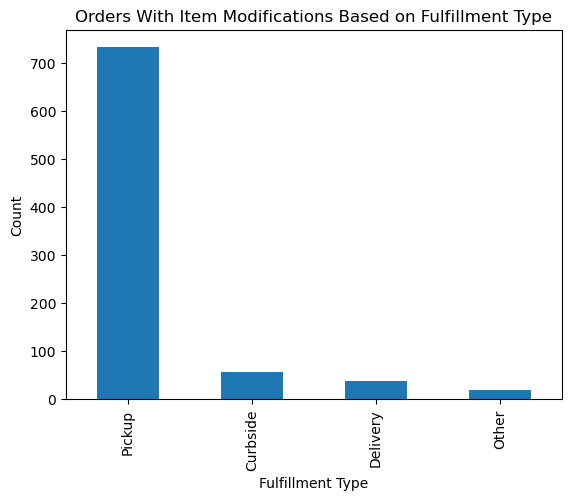

In [77]:
# Visualize relationship between item modifications and fulfillment type

orders_df.groupby(by='Fulfillment Type')['Item Modifiers'].count().sort_values(ascending=False).plot(kind='bar')

plt.title('Orders With Item Modifications Based on Fulfillment Type')
plt.ylabel('Count')
plt.xlabel('Fulfillment Type')

plt.savefig(FIGURES_DIR / 'bar_fulfillment_type_item_modifiers_count.png', bbox_inches='tight')
plt.show()

Orders with modifications are primarily pickup orders.

### Recipient Email

This column is missing 23.8% of its values, so we'll investigate this as well. Most likely this is also a customer preference.

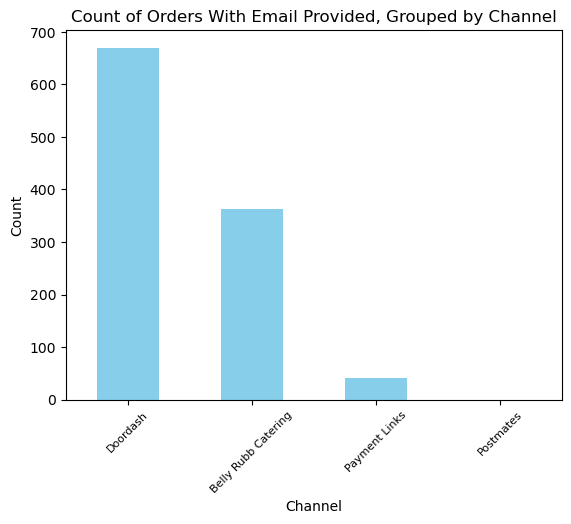

In [78]:
# Visualize count of whose emails were included based on Channel they ordered from

orders_df.groupby(by='Channels')['Recipient Email'].count().sort_values(ascending=False).plot(kind='bar', color='skyblue')

channel_labels = ['Doordash', 'Belly Rubb Catering', 'Payment Links', 'Postmates']

plt.title('Count of Orders With Email Provided, Grouped by Channel')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.xticks(range(len(channel_labels)), labels=channel_labels, rotation=45, fontsize=8)

plt.savefig(FIGURES_DIR / 'bar_email_channel_counts.png', bbox_inches='tight')
plt.show()

It looks like ordering through Postmates does not share customer emails. If emails are important for customer outreach and advertising, perhaps this can be changed.

## Correlations
Some columns are heavily correlated with each other according to the [profile report](/home/arsen/Documents/dsc_projects/belly_rubb_analysis/reports/profile-reports/orders-profile-report.html).

### Channels and Fulfillment Type

In [79]:
fulfillment_set = set(orders_df['Fulfillment Type'])
channels_set = set(orders_df['Channels'])
print(f"Difference: {fulfillment_set.difference(channels_set)}")
print(f"Union: {fulfillment_set.union(channels_set)}")

Difference: {'Curbside', 'Other', 'Pickup', 'Delivery'}
Union: {'Curbside', 'DoorDash', 'Payment Links', 'Delivery', 'Other', 'Postmates Delivery', 'Pickup', 'BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery'}


In [80]:
# View combinations of fulfillment type and channels

orders_df[['Fulfillment Type', 'Channels']].drop_duplicates()

,Fulfillment Type,Channels
0,Pickup,Postmates Delivery
5,Pickup,BELLY RUBB | BBQ Catering | Barbecue To Go and...
9,Pickup,DoorDash
63,Other,Payment Links
68,Curbside,BELLY RUBB | BBQ Catering | Barbecue To Go and...
109,Delivery,BELLY RUBB | BBQ Catering | Barbecue To Go and...
1256,Other,BELLY RUBB | BBQ Catering | Barbecue To Go and...


It looks like delivery orders have only been placed through the kitchen website. There is a chance, however, that a `Pickup` fulfillment type doesn't necessarily mean that it was picked up by the customer. It could potentially indicate that it was picked up by a delivery driver.

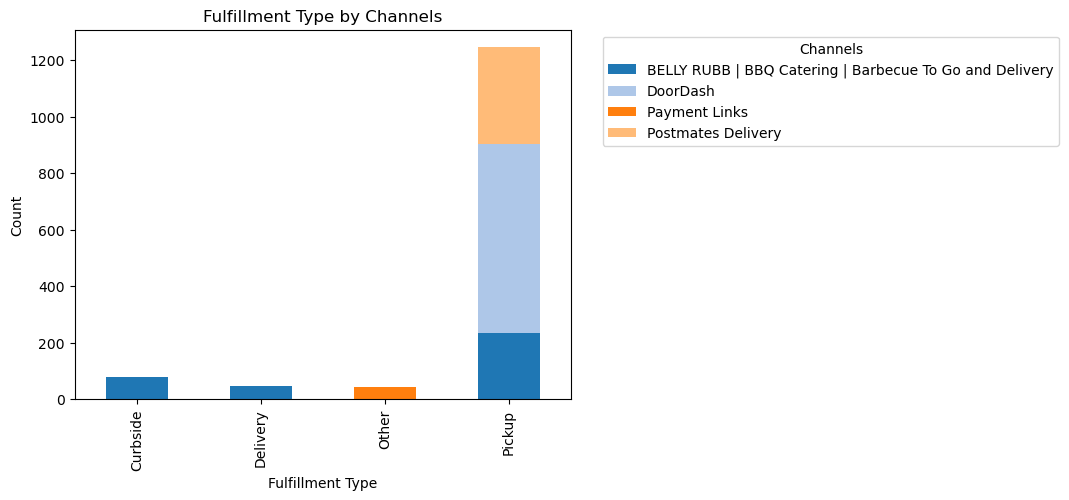

In [81]:
# Visualize how Channels are distributed amongst Fulfillment Types

fulfillment_channels_counts = orders_df.groupby(['Fulfillment Type', 'Channels']).size().unstack(fill_value=0)
fulfillment_channels_counts.plot(
    kind='bar',
    stacked=True,
    color=plt.cm.tab20.colors,
)

plt.title('Fulfillment Type by Channels')
plt.ylabel('Count')
plt.xlabel('Fulfillment Type')
plt.legend(title='Channels', bbox_to_anchor=(1.05, 1))

plt.savefig(FIGURES_DIR / 'stacked_bar_fulfillment_type_channels.png', bbox_inches='tight')
plt.show()

It appears like a majority of orders are labelled as Pickup. This will need to be verified, but it's most likely that Postmates and DoorDash label orders 'picked up' by a delivery driver as such. This is most likely causing the high correlation since all Postmates and Doordash Channels are also Fulfillment type Pickup.

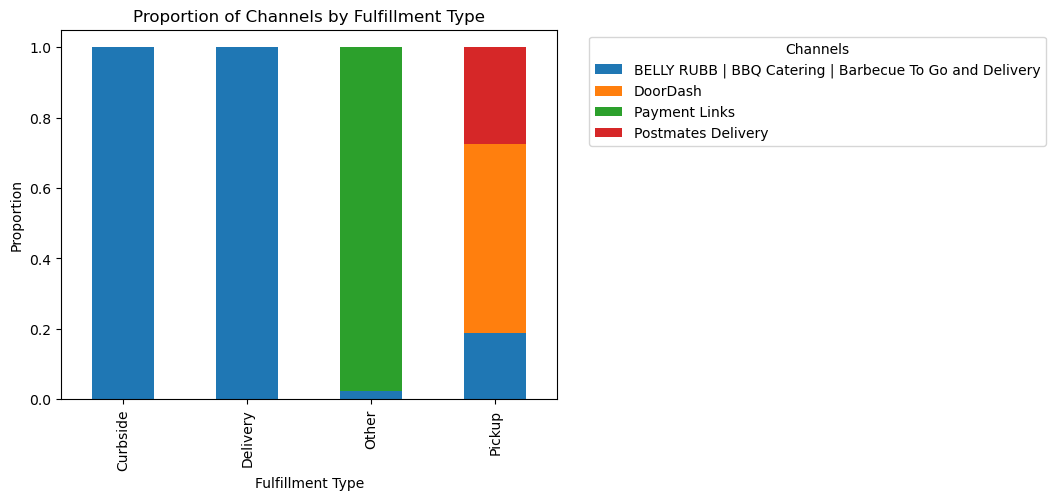

In [82]:
# Visualize proportion of channels by fulfillment type

fullfillment_proportions = fulfillment_channels_counts.div(fulfillment_channels_counts.sum(axis=1), axis=0)
fullfillment_proportions.plot(
    kind='bar',
    stacked=True
)

plt.title('Proportion of Channels by Fulfillment Type')
plt.legend(title='Channels', bbox_to_anchor=(1.05, 1))
plt.xlabel('Fulfillment Type')
plt.ylabel('Proportion')

plt.show()

This visualization verifies that all Curbside and Delivery orders are made through Belly Rubb, that a huge majoriy of Other types are Payment links, and that all Doordash and Postmates orders are Pickup Fulfillment type.

### Channels and Item Options Total Price

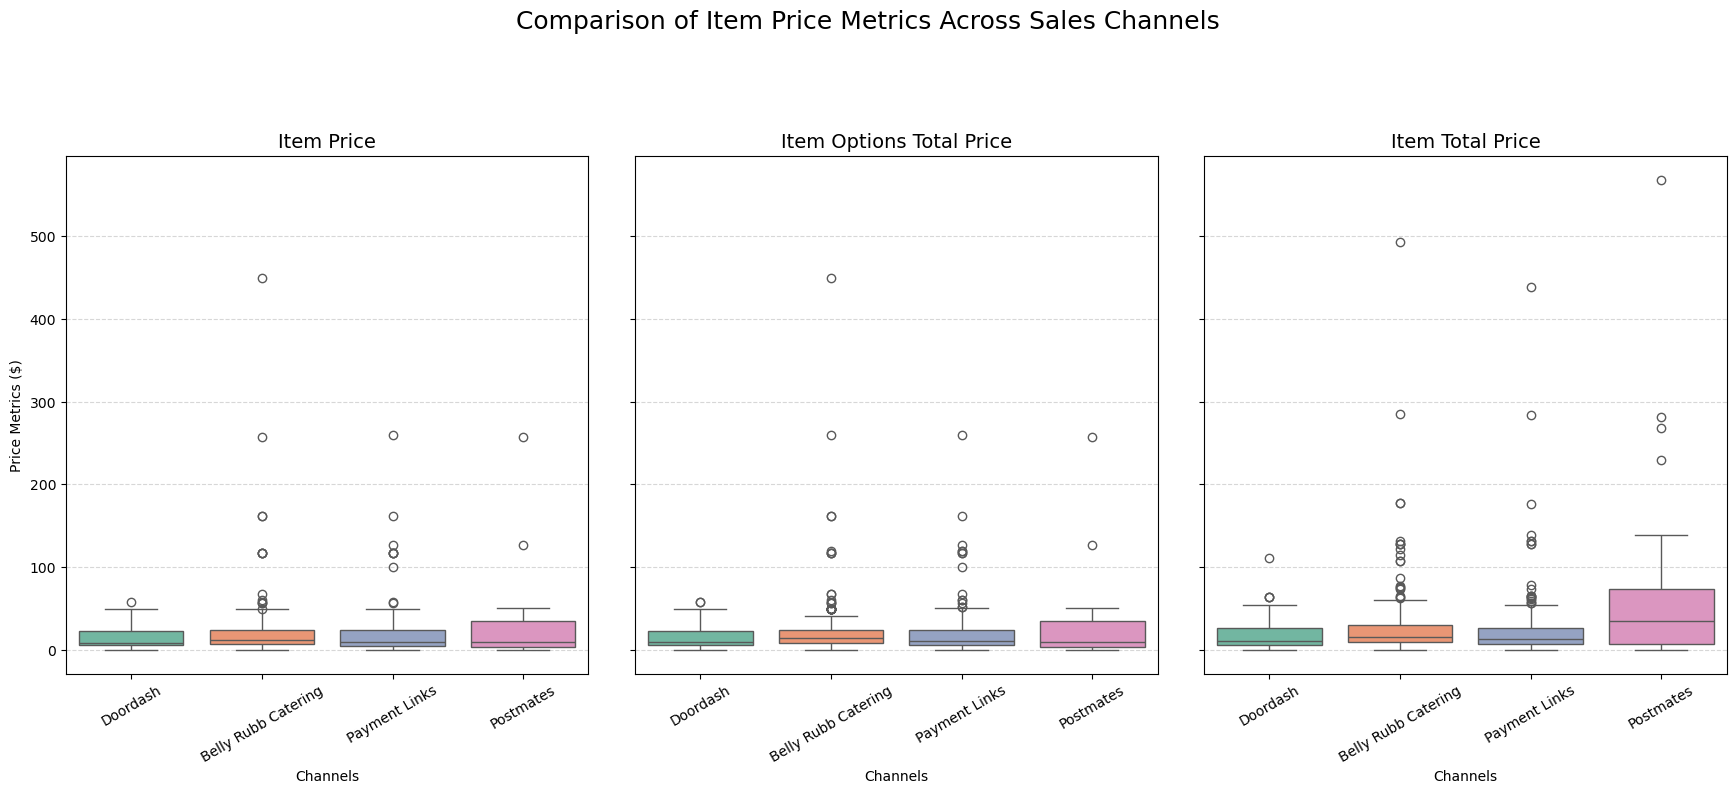

In [83]:
# Visualize relationship between Channels and the different item price metrics

fig, ax = plt.subplots(1, 3, figsize=(18,8), sharey=True)

# Common boxplot features
boxplot_params = {
    'data': orders_df,
    'x': 'Channels',
    'hue': 'Channels',
    'palette': 'Set2'
}

# First boxplot
sns.boxplot(
    y='Item Price',
    ax=ax[0],
    **boxplot_params)

ax[0].set_xticks(range(len(channel_labels)), labels=channel_labels, rotation=30, fontsize=10)
ax[0].set_title('Item Price', fontsize=14)
ax[0].grid(axis='y', linestyle='--', alpha=0.5)

# Second boxplot
sns.boxplot(
    y='Item Options Total Price',
    ax=ax[1],
    **boxplot_params)

ax[1].set_xticks(range(len(channel_labels)), labels=channel_labels, rotation=30, fontsize=10)
ax[1].set_title('Item Options Total Price', fontsize=14)
ax[1].grid(axis='y', linestyle='--', alpha=0.5)

# Third boxplot
sns.boxplot(
    y='Item Total Price',
    ax=ax[2],
    **boxplot_params)

ax[2].set_xticks(range(len(channel_labels)), labels=channel_labels, rotation=30, fontsize=10)
ax[2].set_title('Item Total Price', fontsize=14)
ax[2].grid(axis='y', linestyle='--', alpha=0.5)

# Shared elements
fig.suptitle('Comparison of Item Price Metrics Across Sales Channels', fontsize=18, y=1.02)
ax[0].set_ylabel('Price Metrics ($)')
fig.tight_layout(pad=3.0)

plt.savefig(FIGURES_DIR / 'box_price_metrics_sales_channels.png', bbox_inches='tight')
plt.show()

A few conclusions can be made from these figures:

    - While most of the price, options total price, and total price are concentrated in the $0-50 range, there are some extreme outliers. Doordash contains the fewest outliers, while orders through Belly Rubb have the most.
    - Across channels prices prices are right skewed.
    - The overall increase in prices in Postemates Item Total Price is unexpected.
    - It's clear that there's a correlation between the three pricing columns, explaining the high correlation between them. Since they are linked to a channel, this also explains the correlation with the Channels columns.

## Outliers

We discovered some outliers in our previous exploratory steps which will need to be investigated to understand if there are entry errors or not.

### Postmates Item Total Price
This will look at the outliers in the Total Price ordered through Postmates Delivery channel.

In [84]:
# Calculate upper bound based on iqr

upper_bound = calculate_upper_bound(orders_df, 'Item Total Price')

postmates_outliers = orders_df[(orders_df['Item Total Price'] > upper_bound) & (orders_df['Channels'] == 'Postmates Delivery')]
postmates_outliers

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
15,Uber Eats Delivery 7751A,2024-12-17,113.09,10.74,123.83,2024-12-17 19:56:00,Pickup,Completed,Postmates Delivery,7751A-Lilit A.,NaN,+1 312-766-6835,3,BEEF SHORT RIB,Regular,NaN,33.95,33.95,111.52
160,Uber Eats Delivery DA32F,2024-11-23,89.79,8.53,98.32,2024-11-23 18:30:00,Pickup,Completed,Postmates Delivery,DA32F-Jamie M.,NaN,+1 312-766-6835,1,RIBS & WINGS BUNDLE,Regular,"1 x Sweet&Spicy Glaze, 1 x Signature BBQ glaze...",57.99,57.99,63.50
555,Uber Eats Pickup F7D64,2024-09-27,58.35,5.54,63.89,2024-09-27 14:15:00,Pickup,Completed,Postmates Delivery,F7D64-RENA J.,NaN,+1 312-766-6835,3,CIABATTA STEAK SANDWICH,Regular,NaN,19.45,19.45,63.89
744,Postmates Delivery F63ED,2024-08-23,86.76,8.24,95.00,2024-08-23 17:39:00,Pickup,Completed,Postmates Delivery,F63ED-Barry S.,NaN,+1 312-766-6835,1,SHORT RIB PLATTER,Regular,1 x Add Full-size Pineapple Slaw,49.54,58.05,63.56


In [85]:
# Find all orders by these individuals

outliers_names = postmates_outliers['Recipient Name']
outlier_orders = orders_df[orders_df['Recipient Name'].isin(outliers_names)]

outlier_orders.groupby(by=['Order', 'Recipient Name'])['Item Total Price'].sum()

Order                     Recipient Name
Postmates Delivery F63ED  F63ED-Barry S.     95.00
Uber Eats Delivery 7751A  7751A-Lilit A.    123.83
Uber Eats Delivery DA32F  DA32F-Jamie M.     98.32
Uber Eats Pickup F7D64    F7D64-RENA J.      63.89
Name: Item Total Price, dtype: float64

It looks like these were on time orders by these individuals, however we should also check if they placed orders using other Channels, which may result in their Recipient Name being stored differently.

In [86]:
# Find all orders regardless of how their name is stored

cleaned_names = postmates_outliers['Recipient Name'].str.slice(6,-1)
outlier_orders = orders_df[orders_df['Recipient Name'].apply(lambda x: any(name in x for name in cleaned_names))]

outlier_orders.groupby(by=['Recipient Name'])['Item Total Price'].sum()

Recipient Name
3230D-Jamie M.     17.28
7751A-Lilit A.    123.83
9B66C-Jamie M.     24.01
A23C8-Jamie M.     24.88
C5503-RENA J.      22.38
DA32F-Jamie M.     98.32
F63ED-Barry S.     95.00
F7D64-RENA J.      63.89
Name: Item Total Price, dtype: float64

It looks like Jamie M and Rena J did order multiple times. However, they still only placed such high orders only once.

### Payment Links Item Total Price
Here we will investigate the outliers in the Payment Links channel.

In [87]:
# Get outliers from Payment Links channel

payment_links_outliers = orders_df[(orders_df['Item Total Price'] > upper_bound) & (orders_df['Channels'] == 'Payment Links')]
payment_links_outliers.head()

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
63,Payment Link,2024-12-11,147.00,12.06,159.06,2024-12-11 13:51:00,Other,Completed,Payment Links,Grikor Odjakhian,grikorodjakhian@gmail.com,+18189138445,1,Party Package (4-6 ppl),Regular,"1 x No glaze, 1 x Black Truffle Salt, 1 x Swee...",127.00,127.00,139.06
269,Payment Link,2024-11-07,318.67,30.27,363.94,2024-11-08 11:55:00,Other,Completed,Payment Links,Levon Safaryan,bidium@gmail.com,+1 818-822-5060,2,GLAZED BABY BACK PORK RIBS,Full Rack,1 x Sweet&Spicy Glaze,34.93,34.93,76.50
270,Payment Link,2024-11-07,318.67,30.27,363.94,2024-11-08 11:55:00,Other,Completed,Payment Links,Levon Safaryan,bidium@gmail.com,+1 818-822-5060,3,GLAZED BABY BACK PORK RIBS,Full Rack,1 x Signature BBQ Glaze,34.93,34.93,114.74
273,Payment Link,2024-11-07,318.67,30.27,363.94,2024-11-08 11:55:00,Other,Completed,Payment Links,Levon Safaryan,bidium@gmail.com,+1 818-822-5060,14,GRILLED SWEET CORN,Regular,NaN,3.99,3.99,61.17
303,Payment Link,2024-11-01,461.07,43.80,504.87,2024-11-03 14:45:00,Other,Completed,Payment Links,Tiffany Tapia,strwbrytiff@yahoo.com,+18185715969,1,Party Package (10-12 ppl),Regular,"1 x Salt & Pepper, 1 x Signature BBQ Glaze, 1 ...",257.00,257.00,281.41


In [88]:
# See who is ordering using this channel

payment_links_outliers.groupby(by=['Recipient Name'])['Item Total Price'].sum()

Recipient Name
Grikor Odjakhian     139.06
Levon Safaryan      1686.18
Tiffany Tapia        357.91
Name: Item Total Price, dtype: float64

In [89]:
# Find other orders by these recipients

outlier_recipients = payment_links_outliers['Recipient Name'].unique()
orders_df[orders_df['Recipient Name'].isin(outlier_recipients)]['Channels'].unique()

array(['Payment Links',
       'BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery'],
      dtype=object)

In [90]:
# Get outlier first names and search df using that

outlier_names = [recipient.split(' ')[0] for recipient in outlier_recipients]
outlier_orders = orders_df[orders_df['Recipient Name'].apply(lambda x: any(name in x for name in outlier_names))]

outlier_orders.groupby(by=['Recipient Name', 'Channels'])['Item Total Price'].sum()

Recipient Name    Channels                                               
Grikor Odjakhian  Payment Links                                               159.06
Levon Safaryan    BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery     492.75
                  Payment Links                                              1880.08
Tiffany Nguyen    BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery      46.70
Tiffany Tapia     Payment Links                                               504.87
Name: Item Total Price, dtype: float64

It looks like payment links remain the popular choice for the outliers in this group. Levon is the only one who has also ordered through the Belly Rubb website.

### Belly Rubb Website Channels Item Total Price
Here we investigate outliers in the Belly Rubb website channel.

In [91]:
belly_rubb_outliers = orders_df[(orders_df['Item Total Price'] > upper_bound) & (orders_df['Channels'] == 'BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery')]
belly_rubb_outliers.head()

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
114,Square Online 1423154768,2024-11-28,67.99,6.46,90.24,2024-11-28 15:35:00,Delivery,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,paola munoz,pmunoz@vanguardiaseguros.com.ec,+18187317161,1,RIBS & WINGS BUNDLE,Regular,"1 x Signature BBQ glaze, 1 x Zesty Lemon Peppe...",67.99,67.99,74.45
115,Square Online 1619006283,2024-11-28,162.00,15.39,177.39,2024-11-28 15:35:00,Pickup,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Janet Figueroa,fjanet05@gmail.com,+18187202023,1,Party Package (6-8 ppl),Regular,"1 x Signature BBQ Glaze, 1 x Sweet & Spicy BBQ...",162.00,162.00,177.39
121,Square Online 1167719242,2024-11-28,164.90,15.67,197.06,2024-11-28 16:00:00,Pickup,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Brisseida Ruiz,brissaguirre@gmail.com,+18184553992,1,Party Package (6-8 ppl),Regular,"1 x Signature BBQ Glaze, 1 x Sweet & Spicy BBQ...",162.00,162.00,177.39
146,Square Online 1263982128,2024-11-26,67.49,6.41,80.65,2024-11-26 18:25:00,Curbside,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Tony King,kingkiller0789@gmail.com,+18183563113,1,RIBS & WINGS BUNDLE,Regular,"1 x I want Beef Ribs!, 1 x No glaze, 1 x Zesty...",57.99,67.49,73.90
168,Square Online 1041876247,2024-11-22,357.98,34.01,427.79,2024-11-28 11:31:00,Delivery,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Erika Contreras,contreraserika@sbcglobal.net,+18186254388,1,Party Package (10-12 ppl),Regular,"1 x Signature BBQ Glaze, 1 x Signature BBQ Gla...",257.00,260.00,284.70


In [92]:
outlier_recipients = belly_rubb_outliers['Recipient Name'].unique()
outlier_recipients

array(['paola munoz', 'Janet Figueroa', 'Brisseida Ruiz', 'Tony King',
       'Erika Contreras', 'Sarah Nelson', 'Jacob Khalili-rad',
       'Alvaro Manjarrez', 'Denise Luckhurst', 'Ivanna Felix',
       'Tony Osipof', 'Steven Holland', 'Arin Baharian', 'Ariel Basch',
       'John Vuong', 'Mona Lapides', 'Levon Safaryan',
       'Caroline L Juwono', 'Khoren Mamikonian'], dtype=object)

In [93]:
orders_df[orders_df['Recipient Name'].isin(outlier_recipients)]['Channels'].unique()

array(['BELLY RUBB | BBQ Catering | Barbecue To Go and Delivery',
       'Payment Links'], dtype=object)

In [94]:
belly_rubb_outliers.groupby(by=['Recipient Name', 'Item Name'])['Item Total Price'].sum().sort_values(ascending=False)

Recipient Name     Item Name                 
Erika Contreras    Party Package (10-12 ppl)     284.70
Janet Figueroa     Party Package (6-8 ppl)       177.39
Brisseida Ruiz     Party Package (6-8 ppl)       177.39
Steven Holland     Party Package (4-6 ppl)       131.40
Ariel Basch        Party Package (4-6 ppl)       128.12
Denise Luckhurst   Party Package (4-6 ppl)       128.12
Ivanna Felix       Party Package (4-6 ppl)       128.12
Khoren Mamikonian  GET YOUR BABY BACK!           121.97
Arin Baharian      GLAZED BABY BACK PORK RIBS    114.74
Erika Contreras    BEEF BACK RIBS (Full Rack)    107.29
Arin Baharian      BEEF BACK RIBS (Full Rack)    107.29
Tony Osipof        BABY BACK RIB COMBO            87.56
John Vuong         GLAZED BABY BACK PORK RIBS     77.59
Mona Lapides       GLAZED BABY BACK PORK RIBS     76.50
paola munoz        RIBS & WINGS BUNDLE            74.45
Tony King          RIBS & WINGS BUNDLE            73.90
Caroline L Juwono  THE BABY BACK PARTY-XL         65.70
Mo

It looks like a majority of these orders are party packages, platters, and bundles.

In [95]:
outlier_recipients = [name.split(' ')[0] for name in outlier_recipients]
outliers_orders = orders_df[orders_df['Recipient Name'].apply(lambda x: any(name in x for name in outlier_recipients))]

outlier_orders.head()

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
63,Payment Link,2024-12-11,147.00,12.06,159.06,2024-12-11 13:51:00,Other,Completed,Payment Links,Grikor Odjakhian,grikorodjakhian@gmail.com,+18189138445,1,Party Package (4-6 ppl),Regular,"1 x No glaze, 1 x Black Truffle Salt, 1 x Swee...",127.00,127.00,139.06
64,Payment Link,2024-12-11,147.00,12.06,159.06,2024-12-11 13:51:00,Other,Completed,Payment Links,Grikor Odjakhian,grikorodjakhian@gmail.com,+18189138445,1,Beef Back Ribs Substitution,Regular,NaN,20.00,20.00,20.00
86,Square Online 1900517853,2024-12-03,42.65,4.05,46.70,2024-12-03 16:45:00,Pickup,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Tiffany Nguyen,nguyen.tiffany.t@gmail.com,+14243531880,1,BEEF SHORT RIB,Regular,1 x Signature BBQ Sauce Dip,33.95,35.40,38.76
87,Square Online 1900517853,2024-12-03,42.65,4.05,46.70,2024-12-03 16:45:00,Pickup,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Tiffany Nguyen,nguyen.tiffany.t@gmail.com,+14243531880,1,ARTISAN MAC AND CHEESE,Side,NaN,7.25,7.25,7.94
269,Payment Link,2024-11-07,318.67,30.27,363.94,2024-11-08 11:55:00,Other,Completed,Payment Links,Levon Safaryan,bidium@gmail.com,+1 818-822-5060,2,GLAZED BABY BACK PORK RIBS,Full Rack,1 x Sweet&Spicy Glaze,34.93,34.93,76.50


None of the outliers seemed like data entry mistakes. Therefore no cleaning of outliers will take place.

## Imbalances
Two columns, Fulfillment Type and Fulfillment Status, are highly imbalanced. We already know that fulfillment type is heavily imbalanced because most orders were labeled Pickup. We hypothesize that even orders 'picked up' by a delivery driver are marked as "pickup."

### Fulfillment Status

In [96]:
# List fulfillment status values

orders_df['Fulfillment Status'].unique()

array(['Completed', 'Canceled'], dtype=object)

In [97]:
# Investigate canceled orders

orders_df[orders_df['Fulfillment Status'] == 'Canceled']

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
109,Square Online 431251084,2024-11-28,79.05,7.51,100.55,2024-11-28 16:00:00,Delivery,Canceled,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Myra Tabatabaee,kennysanchez5122@yahoo.com,+18189855274,1,CIABATTA STEAK SANDWICH,Regular,1 x No Arugula,19.45,19.45,21.30
110,Square Online 431251084,2024-11-28,79.05,7.51,100.55,2024-11-28 16:00:00,Delivery,Canceled,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Myra Tabatabaee,kennysanchez5122@yahoo.com,+18189855274,1,GLAZED BABY BACK PORK RIBS,Half rack,1 x Signature BBQ Glaze,23.99,23.99,26.27
111,Square Online 431251084,2024-11-28,79.05,7.51,100.55,2024-11-28 16:00:00,Delivery,Canceled,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Myra Tabatabaee,kennysanchez5122@yahoo.com,+18189855274,1,MOZZARELLA STICKS,6 pcs,NaN,11.36,11.36,12.44
112,Square Online 431251084,2024-11-28,79.05,7.51,100.55,2024-11-28 16:00:00,Delivery,Canceled,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Myra Tabatabaee,kennysanchez5122@yahoo.com,+18189855274,1,BABY BACK RIB COMBO,Regular,"1 x Signature BBQ Glaze, 1 x Mac & Cheese, 1 x...",24.25,24.25,26.55


It looks like only one order was canceled, leading to this imbalance.

## Zeros
Columns Item Price, Item Options Total Price, and Item Total Price have some zeros. We'll investigate these.

In [98]:
zero_items = orders_df[(orders_df['Item Price'] == 0) | (orders_df['Item Options Total Price'] == 0 | (orders_df['Item Total Price'] == 0))]
zero_items.head()

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
61,Square Online 1973126130,2024-12-11,85.12,8.09,101.72,2024-12-11 16:30:00,Pickup,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Mohamed AlAwdi,alawddies@gmail.com,+16146950440,2,KETCHUP,Regular,NaN,0.0,0.0,0.0
75,Uber Eats Delivery B8FFF,2024-12-04,25.44,2.42,27.86,2024-12-04 19:56:00,Pickup,Completed,Postmates Delivery,B8FFF-Anthony J.,NaN,+1 312-766-6835,1,MUSTARD,Regular,NaN,0.0,0.0,0.0
134,DOORDASH,2024-11-27,25.70,2.44,28.14,2024-11-27 16:12:00,Pickup,Completed,DoorDash,Mr. R,point-of-sale-integration@doordash.com,8552228111,1,KETCHUP,Regular,NaN,0.0,0.0,0.0
178,Uber Eats Delivery 1CD03,2024-11-21,45.34,4.31,49.65,2024-11-21 17:52:00,Pickup,Completed,Postmates Delivery,1CD03-Lauren J.,NaN,+1 312-766-6835,6,KETCHUP,Regular,NaN,0.0,0.0,0.0
312,Payment Link,2024-11-01,461.07,43.80,504.87,2024-11-03 14:45:00,Other,Completed,Payment Links,Tiffany Tapia,strwbrytiff@yahoo.com,+18185715969,11,KETCHUP,Regular,NaN,0.0,0.0,0.0


In [99]:
zero_items['Item Name'].unique()

array(['KETCHUP', 'MUSTARD', 'MAYONNAISE'], dtype=object)

Looks like some condiments like keychup, mustard, and mayonnaise are offered for free explaining the $0 price.

# Transactions Dataset

## Cleaning
Cleaning steps are refactored into [dataset.py](belly_rubb_analysis/dataset.py). These include:
- Enforcing correct datatypes from docs/datatypes/
- Dropping columns with more than 72% values missing
- Dropping duplicate rows
- Dropping columns with constant values
- Concatenating datasets pertaining to the same table and sorting them
- Validating categorical values

In [352]:
# Load dataset

trans_df = pd.read_csv(INTERIM_DATA_DIR / 'transactions_interim.csv', parse_dates=['Date', 'Time'])
trans_df.head()

/tmp/ipykernel_239830/1936739778.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  trans_df = pd.read_csv(INTERIM_DATA_DIR / 'transactions_interim.csv', parse_dates=['Date', 'Time'])


,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Discount Name,Transaction Status,Order Reference ID
0,2023-11-27,2025-01-04 18:11:12,10.89,0.0,0.0,10.89,0.00,0.0,0.0,10.89,Point of Sale,10.89,Tapped,0.00,0.0,NaN,-0.38,10.51,sMznCMvA9sG5OwWqBdnWvg3eV,7pgJeys0KWsK5IGLFYCo8fafuaB,Visa,5728.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"French fries (Rosemary, Side), Pineapple Coles...",Payment,For Here,4GBWG86RY6TE2YMWR0JN7S0XQC,Emily Samvalian,0.0,3ZQ9S0C1TFZ91SK87PZJCAJYSX1N,2023-11-29,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,NaN,Complete,NaN
1,2023-11-27,2025-01-04 13:37:08,88.56,0.0,0.0,88.56,0.00,0.0,0.0,88.56,Point of Sale,0.00,NaN,88.56,0.0,NaN,0.00,88.56,GRjFkwdOFJlIXYiHIP6XwNoeV,fTEPnGM8IqeBWDl65MPdzEtRvaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,2 x “Get your baby back” Pork Ribs (Full Rack)...,Payment,Pick Up,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,Complete,NaN
2,2023-11-30,2025-01-04 16:13:48,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,Point of Sale,0.00,NaN,0.00,0.0,NaN,0.00,0.00,wAoPFtaXlYgpRRew5r8c5v1eV,R0IvxtHDAvJRnoqZh3is8pkruaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,"2 x French fries (Rosemary, Full, Voided), “Ge...",Payment,"Pick Up, For Here",NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,Voided,NaN
3,2023-12-05,2025-01-04 16:12:32,44.16,0.0,0.0,44.16,4.20,0.0,0.0,48.36,Square Online,48.36,Keyed,0.00,0.0,NaN,-1.70,46.66,85Ohwx4gPrfiynZJjKgKeJ7k7POZY,FMr15YGavlmjOm2GSxZZJGYwZEWZY,MasterCard,9004.0,NaN,https://app.squareup.com/dashboard/sales/trans...,2 x MAC&CHEESE (8 oz.) - Here’s to taking the ...,Payment,NaN,TQR1MWV3DD53N64TY1FT5YEHP0,Alissa Khachmanyan,0.0,3ZVW7JKH4ZJ10EF4D9BDJ4AJ7TEH,2023-12-05,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,NaN,Complete,11ee93cbd6b99b0caf423cecef6dbaf0
4,2023-12-07,2025-01-04 12:44:33,28.98,0.0,0.0,28.98,2.75,5.8,0.0,37.53,Square Online,37.53,Keyed,0.00,0.0,NaN,-1.39,36.14,EDn6LPZxDq4Md7Th98OE0TQ4Q1GZY,1qsC2RdR9JBEiLBNxsXLJNKQVUNZY,Visa,5658.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Half rack) - Juicy, succu...",Payment,NaN,Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,0.0,3ZSM1F1BGKWS4Q37A590QHYGH655,2023-12-07,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,NaN,Complete,11ee9541284203e6af423cecef6dbaf0


In [353]:
trans_df.shape

(754, 38)

In [354]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 754 non-null    datetime64[ns]
 1   Time                 754 non-null    datetime64[ns]
 2   Gross Sales          754 non-null    float64       
 3   Discounts            754 non-null    float64       
 4   Service Charges      754 non-null    float64       
 5   Net Sales            754 non-null    float64       
 6   Tax                  754 non-null    float64       
 7   Tip                  754 non-null    float64       
 8   Partial Refunds      754 non-null    float64       
 9   Total Collected      754 non-null    float64       
 10  Source               754 non-null    object        
 11  Card                 754 non-null    float64       
 12  Card Entry Methods   284 non-null    object        
 13  Cash                 754 non-null  

In [103]:
trans_df.describe()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Card,Cash,Other Tender,Fees,Net Total,Third Party Fees,Fee Percentage Rate,Fee Fixed Rate
count,754,754,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,284.000000,284.000000
mean,2024-08-03 18:27:41.538461440,2025-01-02 16:01:59.299734528,52.346671,-0.061552,0.272135,52.285119,4.726247,0.878024,-0.134615,57.754775,26.781366,5.490358,25.221698,-1.287056,56.467719,0.422533,2.853169,0.216021
min,2023-11-27 00:00:00,2025-01-02 00:05:39,-358.350000,-5.980000,0.000000,-358.350000,-34.040000,-14.820000,-85.060000,-392.390000,-95.960000,-392.390000,-88.730000,-59.000000,-392.390000,0.000000,2.600000,0.100000
25%,2024-05-29 06:00:00,2025-01-02 13:30:59.249999872,24.450000,0.000000,0.000000,24.450000,2.280000,0.000000,0.000000,27.270000,0.000000,0.000000,0.000000,-1.267500,26.730000,0.000000,2.600000,0.100000
50%,2024-08-27 12:00:00,2025-01-02 16:35:50,40.510000,0.000000,0.000000,40.510000,3.520000,0.000000,0.000000,44.420000,0.000000,0.000000,0.000000,0.000000,43.465000,0.000000,2.900000,0.300000
75%,2024-10-26 00:00:00,2025-01-02 18:30:00.249999872,60.712500,0.000000,0.000000,60.712500,5.547500,0.000000,0.000000,67.277500,37.297500,0.000000,41.127500,0.000000,65.312500,0.000000,2.900000,0.300000
max,2024-12-20 00:00:00,2025-01-02 22:58:24,1039.950000,1.700000,35.800000,1039.950000,98.800000,25.000000,0.000000,1158.750000,1158.750000,392.390000,487.110000,15.490000,1124.850000,46.290000,6.000000,0.300000
std,NaN,NaN,66.398362,0.514331,2.132437,66.404395,6.204880,2.963521,3.148047,73.867019,70.637660,30.354223,38.057782,4.173847,71.739622,3.040319,0.306624,0.095751


## Missing Values

All columns with more than 72% data missing were dropped. This leaves the following columns with missing values to investigate:
- Card Entry Methods
- Other Tender Type
- Tender Note
- Card Brand
- PAN Suffix
- Device Name
- Dining Option
- Customer ID
- Customer Name
- Deposit ID
- Deposit Date
- Deposit Details
- Fee Percentage Rate
- Fee Fixed Rate
- Order Reference ID
- Unattributed Tips

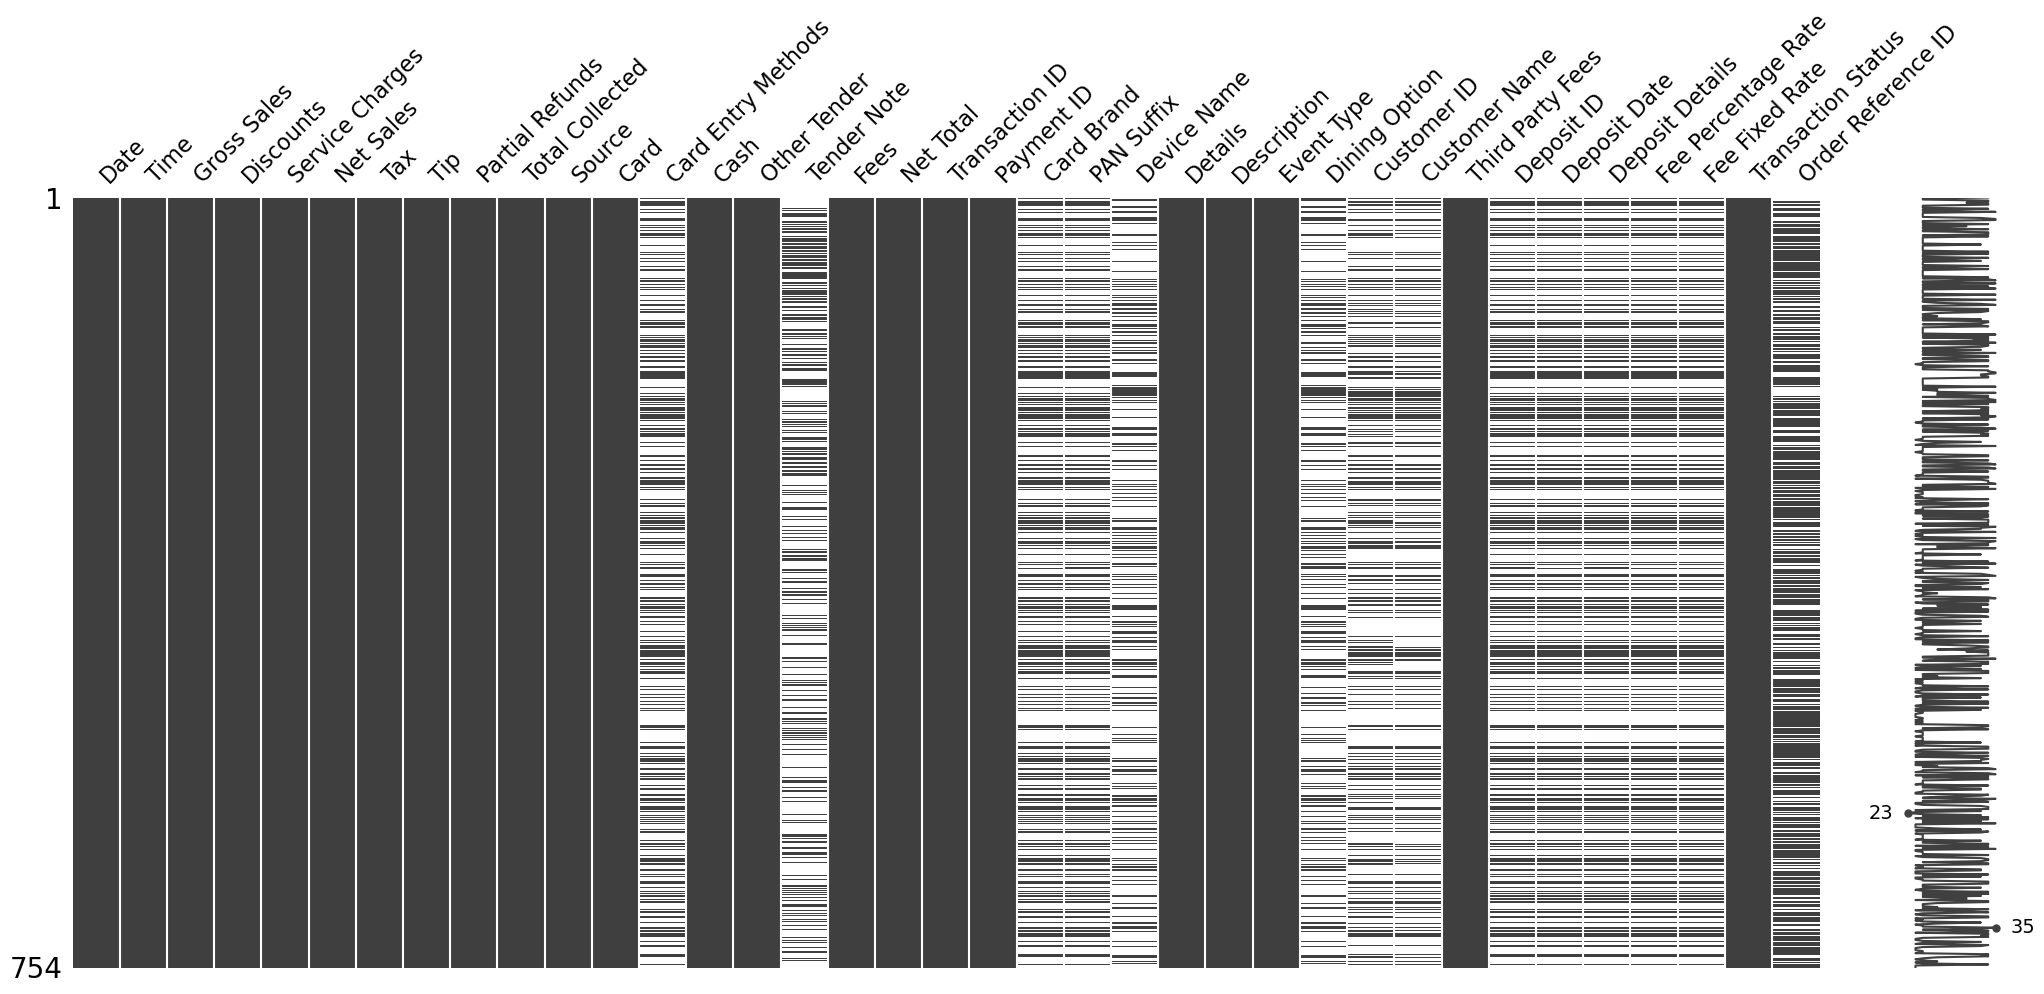

In [104]:
# Visualize missingness matrix

msno.matrix(df=trans_df)

plt.show()

A few columns' missingness is correlated:
1. Card entry methods, Card Brand, and PAN Suffix
2. Customer ID and Customer Name
3. Deposit ID, Deposit Date, Deposite Details, Fee Percentage Rate, and Fee Fixed Rate
4. 1 and 3 are also correlated

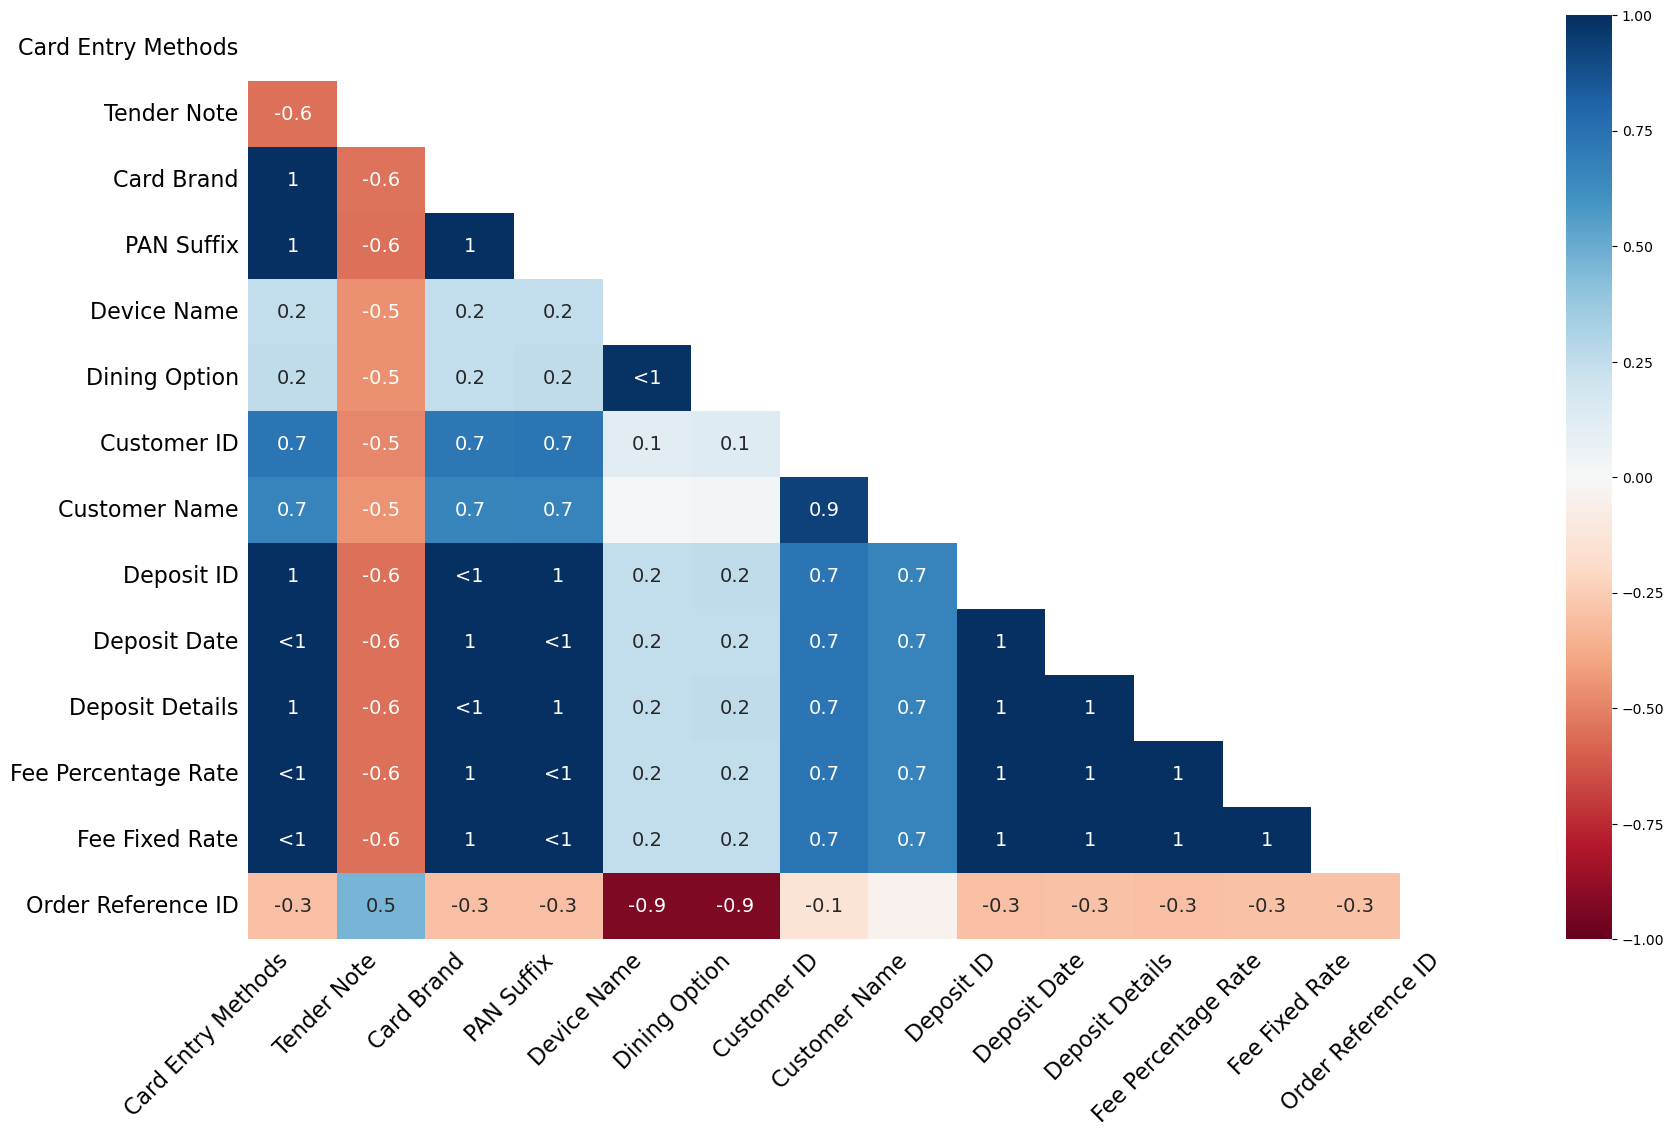

In [105]:
# Visualize missingness correlations

msno.heatmap(trans_df)

plt.show()

### Card and Deposit Columns

Missingness in columns containing card information and deposit information are strongly correlated. This will be investigated to determine the kind of missingness.

In [129]:
# Subset for completed transactions

complete_trans = trans_df[trans_df['Transaction Status'] == 'Complete']
complete_trans

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
0,2023-11-27,2025-01-02 18:11:12,10.89,0.0,0.0,10.89,0.00,0.00,0.0,10.89,Point of Sale,10.89,Tapped,0.00,0.00,NaN,-0.38,10.51,sMznCMvA9sG5OwWqBdnWvg3eV,7pgJeys0KWsK5IGLFYCo8fafuaB,Visa,5728.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"French fries (Rosemary, Side), Pineapple Coles...",Payment,For Here,4GBWG86RY6TE2YMWR0JN7S0XQC,Emily Samvalian,0.0,3ZQ9S0C1TFZ91SK87PZJCAJYSX1N,2023-11-29,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN
1,2023-11-27,2025-01-02 13:37:08,88.56,0.0,0.0,88.56,0.00,0.00,0.0,88.56,Point of Sale,0.00,NaN,88.56,0.00,NaN,0.00,88.56,GRjFkwdOFJlIXYiHIP6XwNoeV,fTEPnGM8IqeBWDl65MPdzEtRvaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,2 x “Get your baby back” Pork Ribs (Full Rack)...,Payment,Pick Up,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,NaN
3,2023-12-05,2025-01-02 16:12:32,44.16,0.0,0.0,44.16,4.20,0.00,0.0,48.36,Square Online,48.36,Keyed,0.00,0.00,NaN,-1.70,46.66,85Ohwx4gPrfiynZJjKgKeJ7k7POZY,FMr15YGavlmjOm2GSxZZJGYwZEWZY,MasterCard,9004.0,NaN,https://app.squareup.com/dashboard/sales/trans...,2 x MAC&CHEESE (8 oz.) - Here’s to taking the ...,Payment,NaN,TQR1MWV3DD53N64TY1FT5YEHP0,Alissa Khachmanyan,0.0,3ZVW7JKH4ZJ10EF4D9BDJ4AJ7TEH,2023-12-05,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,11ee93cbd6b99b0caf423cecef6dbaf0
4,2023-12-07,2025-01-02 12:44:33,28.98,0.0,0.0,28.98,2.75,5.80,0.0,37.53,Square Online,37.53,Keyed,0.00,0.00,NaN,-1.39,36.14,EDn6LPZxDq4Md7Th98OE0TQ4Q1GZY,1qsC2RdR9JBEiLBNxsXLJNKQVUNZY,Visa,5658.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Half rack) - Juicy, succu...",Payment,NaN,Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,0.0,3ZSM1F1BGKWS4Q37A590QHYGH655,2023-12-07,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,11ee9541284203e6af423cecef6dbaf0
5,2023-12-09,2025-01-02 14:29:54,-74.10,0.0,0.0,-74.10,-7.04,-14.82,0.0,-95.96,Point of Sale,-95.96,Keyed,0.00,0.00,NaN,0.00,-95.96,uVh61UleK3NqFaLKt9YpWG2eV,bLxBY8QZHfkvM78ktCGQp9E5g6WZY,MasterCard,299.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Full Rack) - Juicy, succu...",Refund,NaN,NaN,NaN,0.0,3Z7CHTKRCQWX0Y711HZ9C4C2F2A5,2023-12-09,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,2024-12-19,2025-01-02 21:06:36,37.46,0.0,0.0,37.46,3.56,0.00,0.0,41.02,Point of Sale,0.00,NaN,41.02,0.00,NaN,0.00,41.02,27ARtgJmvdGYMN6Q3oUKeNieV,ftpZEjxIjifWs7uqDIN7dNzRuaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,"CRINKLE FRIES (Side) - Onions/bbq, GLAZED BABY...",Payment,Pick Up,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,NaN
750,2024-12-19,2025-01-02 12:18:49,63.34,0.0,0.0,63.34,6.02,6.33,0.0,75.69,Square Online,75.69,Keyed,0.00,0.00,NaN,-2.50,73.19,0rBd81PH9QYDGA1neACtoOcCjWLZY,NUPEuRvVIiLATIcu66QPAjKCVUOZY,MasterCard,4305,NaN,https://app.squareup.com/dashboard/sales/trans...,"BEEF BACK RIBS (Full Rack) (Regular) - Juicy, ...",Payment,NaN,PXKHFYGYSS3N37MPV5CPWVXN5R,Rip Geru- Maa,0.0,3ZY3NPFDXY610V71C4TXK50CSVB1,2024-12-19,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,11efbe418020b59bbd5e3cecef6dbaf0
751,2024-12-19,2025-01-02 11:01:55,22.06,0.0,0.0,22.06,1.20,0.00,0.0,23.26,Postmates Delivery,0.00,NaN,0.00,23.26,NaN,0.00,23.26,2gzJwXWSFWBgbCAe5CeD8kiwIsFZY,V0vPNSEh0b2HGJV2KheBdmxYCHJZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,PINEAPPLE SLAW (Fu

In [130]:
# View rows where neither Card Brand nor PAN Suffix are missing

brand_pan_not_null = complete_trans[complete_trans['Card Brand'].notnull() & complete_trans['PAN Suffix'].notnull()]
brand_pan_not_null.head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
0,2023-11-27,2025-01-02 18:11:12,10.89,0.0,0.0,10.89,0.00,0.00,0.0,10.89,Point of Sale,10.89,Tapped,0.0,0.0,NaN,-0.38,10.51,sMznCMvA9sG5OwWqBdnWvg3eV,7pgJeys0KWsK5IGLFYCo8fafuaB,Visa,5728.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"French fries (Rosemary, Side), Pineapple Coles...",Payment,For Here,4GBWG86RY6TE2YMWR0JN7S0XQC,Emily Samvalian,0.0,3ZQ9S0C1TFZ91SK87PZJCAJYSX1N,2023-11-29,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN
3,2023-12-05,2025-01-02 16:12:32,44.16,0.0,0.0,44.16,4.20,0.00,0.0,48.36,Square Online,48.36,Keyed,0.0,0.0,NaN,-1.70,46.66,85Ohwx4gPrfiynZJjKgKeJ7k7POZY,FMr15YGavlmjOm2GSxZZJGYwZEWZY,MasterCard,9004.0,NaN,https://app.squareup.com/dashboard/sales/trans...,2 x MAC&CHEESE (8 oz.) - Here’s to taking the ...,Payment,NaN,TQR1MWV3DD53N64TY1FT5YEHP0,Alissa Khachmanyan,0.0,3ZVW7JKH4ZJ10EF4D9BDJ4AJ7TEH,2023-12-05,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,11ee93cbd6b99b0caf423cecef6dbaf0
4,2023-12-07,2025-01-02 12:44:33,28.98,0.0,0.0,28.98,2.75,5.80,0.0,37.53,Square Online,37.53,Keyed,0.0,0.0,NaN,-1.39,36.14,EDn6LPZxDq4Md7Th98OE0TQ4Q1GZY,1qsC2RdR9JBEiLBNxsXLJNKQVUNZY,Visa,5658.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Half rack) - Juicy, succu...",Payment,NaN,Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,0.0,3ZSM1F1BGKWS4Q37A590QHYGH655,2023-12-07,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,11ee9541284203e6af423cecef6dbaf0
5,2023-12-09,2025-01-02 14:29:54,-74.10,0.0,0.0,-74.10,-7.04,-14.82,0.0,-95.96,Point of Sale,-95.96,Keyed,0.0,0.0,NaN,0.00,-95.96,uVh61UleK3NqFaLKt9YpWG2eV,bLxBY8QZHfkvM78ktCGQp9E5g6WZY,MasterCard,299.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Full Rack) - Juicy, succu...",Refund,NaN,NaN,NaN,0.0,3Z7CHTKRCQWX0Y711HZ9C4C2F2A5,2023-12-09,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,NaN
6,2023-12-09,2025-01-02 13:19:42,74.10,0.0,0.0,74.10,7.04,14.82,0.0,95.96,Square Online,95.96,Keyed,0.0,0.0,NaN,-3.08,92.88,EdI6bYmV3RObEJPKCymrNv6EIQLZY,bLxBY8QZHfkvM78ktCGQp9E5g6WZY,MasterCard,299.0,NaN,https://app.squareup.com/dashboard/sales/trans...,THE BABY BACK COMBO (Crinkle Fries- Rosemary P...,Payment,NaN,0BGYJMQ4GZT0VTE3D98AE51TER,Arus Keshishyan,0.0,3ZVRCC2PGJN57D3BP3H1GXA5CW1H,2023-12-09,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,11ee96d8028fa2aaaf423cecef6dbaf0


In [107]:
# Card Brands

brand_pan_not_null['Card Brand'].unique()

array(['Visa', 'MasterCard', 'American Express', 'Discover'], dtype=object)

In [131]:
# Transactions with no card brand

brand_null = complete_trans[complete_trans['Card Brand'].isnull()]
brand_null.head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
1,2023-11-27,2025-01-02 13:37:08,88.56,0.0,0.0,88.56,0.00,0.0,0.0,88.56,Point of Sale,0.0,NaN,88.56,0.00,NaN,0.0,88.56,GRjFkwdOFJlIXYiHIP6XwNoeV,fTEPnGM8IqeBWDl65MPdzEtRvaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,2 x “Get your baby back” Pork Ribs (Full Rack)...,Payment,Pick Up,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,NaN
10,2023-12-28,2025-01-02 13:10:12,9.34,0.0,0.0,9.34,0.89,0.0,0.0,10.23,DOORDASH,0.0,NaN,0.00,10.23,DoorDash 32511734-9c22-3001-85cd-9fa25d985929,0.0,10.23,G8NtqxpsCGVw3ZYlOPLHKyBjhJIZY,xGDUfOjmaBMmbGWAkpO9Ba3xrDSZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,"CRINKLE FRIES (Full, Truffle salt) - Golden, c...",Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,09884d10-ac90-401c-9333-640b45fb3ad5
12,2023-12-30,2025-01-02 15:29:25,53.40,0.0,0.0,53.40,4.31,0.0,0.0,57.71,DOORDASH,0.0,NaN,0.00,57.71,DoorDash 4201350b-a048-407c-b448-026314821e3d,0.0,57.71,2yCSwAHZecEBnU0UjxHAC9cLFmLZY,fXGzLpFcKyqzD2BiXsA1c2UtN09YY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,"BELLY SLIDERS (4 sliders) - Tender, glazed por...",Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,4644fd4e-ae1e-4057-9c63-807e034f4611
15,2024-01-03,2025-01-02 14:04:45,24.84,0.0,0.0,24.84,2.36,0.0,0.0,27.20,DOORDASH,0.0,NaN,0.00,27.20,DoorDash f51e9461-94b1-405c-9b67-739d4897841f,0.0,27.20,wVP7Hej4tBfoa5qu8yuOwe7xGNQZY,jB02AoC0BQAdzXbhMUTzXPvdA48YY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Half rack) - Juicy, succu...",Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,8a8fc68b-85de-41d0-8263-82abe3b868f4
16,2024-01-04,2025-01-02 16:58:39,35.37,0.0,0.0,35.37,2.60,0.0,0.0,37.97,DOORDASH,0.0,NaN,0.00,37.97,DoorDash dcfc3897-d998-4a76-9370-a4c9a8d141e0,0.0,37.97,Alj33VmyfYStTvPvwtHsoAzflfLZY,RONnP9BClsZJmGlPxDr7AEwfS1XZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,GRILLED SWEET CORN (Regular) - Grilled sweet c...,Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,b14bc1df-d4ef-45a5-9eed-fb9ac0694ece


In [65]:
brand_null['Card'].describe()

count    470.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Card, dtype: float64

In [66]:
brand_null['Cash'].describe()

count    470.000000
mean       8.807936
std       38.079268
min     -392.390000
25%        0.000000
50%        0.000000
75%        0.000000
max      392.390000
Name: Cash, dtype: float64

In [132]:
complete_trans[complete_trans['Card Brand'].isnull() & complete_trans['PAN Suffix'].notnull()]

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID


In [133]:
# Rows with no deposit date

deposit_null = complete_trans[complete_trans['Deposit Date'].isnull()]
deposit_null

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
1,2023-11-27,2025-01-02 13:37:08,88.56,0.0,0.0,88.56,0.00,0.0,0.0,88.56,Point of Sale,0.0,NaN,88.56,0.00,NaN,0.0,88.56,GRjFkwdOFJlIXYiHIP6XwNoeV,fTEPnGM8IqeBWDl65MPdzEtRvaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,2 x “Get your baby back” Pork Ribs (Full Rack)...,Payment,Pick Up,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,NaN
10,2023-12-28,2025-01-02 13:10:12,9.34,0.0,0.0,9.34,0.89,0.0,0.0,10.23,DOORDASH,0.0,NaN,0.00,10.23,DoorDash 32511734-9c22-3001-85cd-9fa25d985929,0.0,10.23,G8NtqxpsCGVw3ZYlOPLHKyBjhJIZY,xGDUfOjmaBMmbGWAkpO9Ba3xrDSZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,"CRINKLE FRIES (Full, Truffle salt) - Golden, c...",Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,09884d10-ac90-401c-9333-640b45fb3ad5
12,2023-12-30,2025-01-02 15:29:25,53.40,0.0,0.0,53.40,4.31,0.0,0.0,57.71,DOORDASH,0.0,NaN,0.00,57.71,DoorDash 4201350b-a048-407c-b448-026314821e3d,0.0,57.71,2yCSwAHZecEBnU0UjxHAC9cLFmLZY,fXGzLpFcKyqzD2BiXsA1c2UtN09YY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,"BELLY SLIDERS (4 sliders) - Tender, glazed por...",Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,4644fd4e-ae1e-4057-9c63-807e034f4611
15,2024-01-03,2025-01-02 14:04:45,24.84,0.0,0.0,24.84,2.36,0.0,0.0,27.20,DOORDASH,0.0,NaN,0.00,27.20,DoorDash f51e9461-94b1-405c-9b67-739d4897841f,0.0,27.20,wVP7Hej4tBfoa5qu8yuOwe7xGNQZY,jB02AoC0BQAdzXbhMUTzXPvdA48YY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Half rack) - Juicy, succu...",Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,8a8fc68b-85de-41d0-8263-82abe3b868f4
16,2024-01-04,2025-01-02 16:58:39,35.37,0.0,0.0,35.37,2.60,0.0,0.0,37.97,DOORDASH,0.0,NaN,0.00,37.97,DoorDash dcfc3897-d998-4a76-9370-a4c9a8d141e0,0.0,37.97,Alj33VmyfYStTvPvwtHsoAzflfLZY,RONnP9BClsZJmGlPxDr7AEwfS1XZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,GRILLED SWEET CORN (Regular) - Grilled sweet c...,Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,b14bc1df-d4ef-45a5-9eed-fb9ac0694ece
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,2024-12-19,2025-01-02 18:14:02,40.12,0.0,0.0,40.12,3.81,0.0,0.0,43.93,Uber Eats Delivery,0.0,NaN,0.00,43.93,NaN,0.0,43.93,2yOoGdYSFvZRHxhsOSSkEJjxFNXZY,VMh8gh6UDDO9NHBN4cjHxiKLf85YY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,LOADED FRIES (Regular) - Load up our crispy cr...,Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,27d82d1b-934c-4dd7-96e6-b59aea286b6c
749,2024-12-19,2025-01-02 21:06:36,37.46,0.0,0.0,37.46,3.56,0.0,0.0,41.02,Point of Sale,0.0,NaN,41.02,0.00,NaN,0.0,41.02,27ARtgJmvdGYMN6Q3oUKeNieV,ftpZEjxIjifWs7uqDIN7dNzRuaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,"CRINKLE FRIES (Side) - Onions/bbq, GLAZED BABY...",Payment,Pick Up,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,NaN
751,2024-12-19,2025-01-02 11:01:55,22.06,0.0,0.0,22.06,1.20,0.0,0.0,23.26,Postmates Delivery,0.0,NaN,0.00,23.26,NaN,0.0,23.26,2gzJwXWSFWBgbCAe5CeD8kiwIsFZY,V0vPNSEh0b2HGJV2KheBdmxYCHJZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,PINEAPPLE SLAW (Full) - Fruity meets smokey in...,Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,c3976dd3-9d48-4b7e-a068-2de0893eaa45
752,2024-12-19,2025-01-02 14:34:03,32.19,0.0,0.0,32.19,3.06,0.0,0.0,35.25,Uber Eats Delivery,0.0,NaN,0.00,35.25,NaN,0.0,35.25,aKZCc6bo1YtLdZXGoeY7mB2iooAZY,FoVXJzew168yXlsZBx1NyUTs48RZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,CIABAT

In [112]:
# Rows with no deposit date with a card transaction above 0

deposit_null[deposit_null.Card > 0]

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
361,2024-08-22,2025-01-02 11:05:13,528.85,0.0,0.0,528.85,50.24,0.0,0.0,579.09,Invoices,579.09,Keyed,0.0,0.0,NaN,-19.71,559.38,cT37Y7nBLHnyGPuueDijHoNnFZfZY,"pKRvgVdCTj92QE0UJ41FUD2FcZXZY, vVDKmnAFPX0KUn3...",NaN,"0401, 0401",NaN,https://app.squareup.com/dashboard/sales/trans...,Party Package (10-12 ppl) (Regular) - Save you...,Payment,Pick Up,"Y83FHNB8YVD58FPBS8WR3K4P8G, Y83FHNB8YVD58FPBS8...","Cynthia Rodriguez, Cynthia Rodriguez",0.0,"3ZPD7FZQCPX16SN0WQ98QMHW9E5N, 3ZB5FHSFXP8565S5...",NaN,https://app.squareup.com/dashboard/sales/depos...,NaN,NaN,Complete,NaN


In [114]:
# Drop outlier row

complete_trans = complete_trans.drop(361)

In [119]:
complete_trans['Fee Percentage Rate'].unique()

array([2.6, nan, 2.9, 3.5, 3.3, 6. ])

In [120]:
complete_trans['Fee Fixed Rate'].unique()

array([0.1 ,  nan, 0.3 , 0.15])

In [138]:
null_fees = complete_trans[complete_trans['Fee Fixed Rate'].isnull() & complete_trans['Fee Percentage Rate'].isnull()]
null_fees.head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
1,2023-11-27,2025-01-02 13:37:08,88.56,0.0,0.0,88.56,0.00,0.0,0.0,88.56,Point of Sale,0.0,NaN,88.56,0.00,NaN,0.0,88.56,GRjFkwdOFJlIXYiHIP6XwNoeV,fTEPnGM8IqeBWDl65MPdzEtRvaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,2 x “Get your baby back” Pork Ribs (Full Rack)...,Payment,Pick Up,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,NaN
10,2023-12-28,2025-01-02 13:10:12,9.34,0.0,0.0,9.34,0.89,0.0,0.0,10.23,DOORDASH,0.0,NaN,0.00,10.23,DoorDash 32511734-9c22-3001-85cd-9fa25d985929,0.0,10.23,G8NtqxpsCGVw3ZYlOPLHKyBjhJIZY,xGDUfOjmaBMmbGWAkpO9Ba3xrDSZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,"CRINKLE FRIES (Full, Truffle salt) - Golden, c...",Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,09884d10-ac90-401c-9333-640b45fb3ad5
12,2023-12-30,2025-01-02 15:29:25,53.40,0.0,0.0,53.40,4.31,0.0,0.0,57.71,DOORDASH,0.0,NaN,0.00,57.71,DoorDash 4201350b-a048-407c-b448-026314821e3d,0.0,57.71,2yCSwAHZecEBnU0UjxHAC9cLFmLZY,fXGzLpFcKyqzD2BiXsA1c2UtN09YY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,"BELLY SLIDERS (4 sliders) - Tender, glazed por...",Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,4644fd4e-ae1e-4057-9c63-807e034f4611
15,2024-01-03,2025-01-02 14:04:45,24.84,0.0,0.0,24.84,2.36,0.0,0.0,27.20,DOORDASH,0.0,NaN,0.00,27.20,DoorDash f51e9461-94b1-405c-9b67-739d4897841f,0.0,27.20,wVP7Hej4tBfoa5qu8yuOwe7xGNQZY,jB02AoC0BQAdzXbhMUTzXPvdA48YY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Half rack) - Juicy, succu...",Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,8a8fc68b-85de-41d0-8263-82abe3b868f4
16,2024-01-04,2025-01-02 16:58:39,35.37,0.0,0.0,35.37,2.60,0.0,0.0,37.97,DOORDASH,0.0,NaN,0.00,37.97,DoorDash dcfc3897-d998-4a76-9370-a4c9a8d141e0,0.0,37.97,Alj33VmyfYStTvPvwtHsoAzflfLZY,RONnP9BClsZJmGlPxDr7AEwfS1XZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,GRILLED SWEET CORN (Regular) - Grilled sweet c...,Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,b14bc1df-d4ef-45a5-9eed-fb9ac0694ece


In [139]:
null_fees.describe()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Card,Cash,Other Tender,Fees,Net Total,Third Party Fees,Fee Percentage Rate,Fee Fixed Rate
count,447,447,447.000000,447.0,447.0,447.000000,447.000000,447.0,447.0,447.000000,447.0,447.000000,447.000000,447.0,447.000000,447.0,0.0,0.0
mean,2024-08-08 01:14:05.637583872,2025-01-02 16:20:38.315436288,47.539575,0.0,0.0,47.539575,4.265548,0.0,0.0,51.805123,0.0,9.261141,42.543982,0.0,51.805123,0.0,NaN,NaN
min,2023-11-27 00:00:00,2025-01-02 01:46:37,-358.350000,0.0,0.0,-358.350000,-34.040000,0.0,0.0,-392.390000,0.0,-392.390000,-88.730000,0.0,-392.390000,0.0,NaN,NaN
25%,2024-05-31 00:00:00,2025-01-02 13:51:33.500000,26.005000,0.0,0.0,26.005000,2.345000,0.0,0.0,28.475000,0.0,0.000000,21.890000,0.0,28.475000,0.0,NaN,NaN
50%,2024-08-31 00:00:00,2025-01-02 16:56:20,38.950000,0.0,0.0,38.950000,3.420000,0.0,0.0,42.150000,0.0,0.000000,38.300000,0.0,42.150000,0.0,NaN,NaN
75%,2024-10-30 00:00:00,2025-01-02 18:47:59,58.015000,0.0,0.0,58.015000,5.230000,0.0,0.0,63.260000,0.0,0.000000,57.940000,0.0,63.260000,0.0,NaN,NaN
max,2024-12-20 00:00:00,2025-01-02 22:23:16,444.850000,0.0,0.0,444.850000,42.260000,0.0,0.0,487.110000,0.0,392.390000,487.110000,0.0,487.110000,0.0,NaN,NaN
std,NaN,NaN,45.164389,0.0,0.0,45.164389,4.234681,0.0,0.0,49.372013,0.0,38.994890,41.313106,0.0,49.372013,0.0,NaN,NaN


In [140]:
null_fees = complete_trans[complete_trans['Fee Fixed Rate'].isnull() | complete_trans['Fee Percentage Rate'].isnull()]
null_fees.head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
1,2023-11-27,2025-01-02 13:37:08,88.56,0.0,0.0,88.56,0.00,0.0,0.0,88.56,Point of Sale,0.0,NaN,88.56,0.00,NaN,0.0,88.56,GRjFkwdOFJlIXYiHIP6XwNoeV,fTEPnGM8IqeBWDl65MPdzEtRvaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,2 x “Get your baby back” Pork Ribs (Full Rack)...,Payment,Pick Up,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,NaN
10,2023-12-28,2025-01-02 13:10:12,9.34,0.0,0.0,9.34,0.89,0.0,0.0,10.23,DOORDASH,0.0,NaN,0.00,10.23,DoorDash 32511734-9c22-3001-85cd-9fa25d985929,0.0,10.23,G8NtqxpsCGVw3ZYlOPLHKyBjhJIZY,xGDUfOjmaBMmbGWAkpO9Ba3xrDSZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,"CRINKLE FRIES (Full, Truffle salt) - Golden, c...",Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,09884d10-ac90-401c-9333-640b45fb3ad5
12,2023-12-30,2025-01-02 15:29:25,53.40,0.0,0.0,53.40,4.31,0.0,0.0,57.71,DOORDASH,0.0,NaN,0.00,57.71,DoorDash 4201350b-a048-407c-b448-026314821e3d,0.0,57.71,2yCSwAHZecEBnU0UjxHAC9cLFmLZY,fXGzLpFcKyqzD2BiXsA1c2UtN09YY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,"BELLY SLIDERS (4 sliders) - Tender, glazed por...",Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,4644fd4e-ae1e-4057-9c63-807e034f4611
15,2024-01-03,2025-01-02 14:04:45,24.84,0.0,0.0,24.84,2.36,0.0,0.0,27.20,DOORDASH,0.0,NaN,0.00,27.20,DoorDash f51e9461-94b1-405c-9b67-739d4897841f,0.0,27.20,wVP7Hej4tBfoa5qu8yuOwe7xGNQZY,jB02AoC0BQAdzXbhMUTzXPvdA48YY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Half rack) - Juicy, succu...",Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,8a8fc68b-85de-41d0-8263-82abe3b868f4
16,2024-01-04,2025-01-02 16:58:39,35.37,0.0,0.0,35.37,2.60,0.0,0.0,37.97,DOORDASH,0.0,NaN,0.00,37.97,DoorDash dcfc3897-d998-4a76-9370-a4c9a8d141e0,0.0,37.97,Alj33VmyfYStTvPvwtHsoAzflfLZY,RONnP9BClsZJmGlPxDr7AEwfS1XZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,GRILLED SWEET CORN (Regular) - Grilled sweet c...,Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,b14bc1df-d4ef-45a5-9eed-fb9ac0694ece


In [141]:
complete_trans['Fee Percentage Rate'].unique()

array([2.6, nan, 2.9, 3.5, 3.3, 6. ])

In [142]:
complete_trans['Fee Fixed Rate'].unique()

array([0.1 ,  nan, 0.3 , 0.15])

#### Conclusions
- PAN Suffix and Card Brand are missing for transactions made with cash. It naturally follows that Card Entry Method's missingness will be correlated to this. 
- Deposits only occur when transactions are made with a card. 
- Transactions made without cards have no fees. Missing values in these columns actually correspond to values of 0.

#### Investigate Fee Structure

It's not entirely clear how fees are determined. We explore their relationship to other features here.

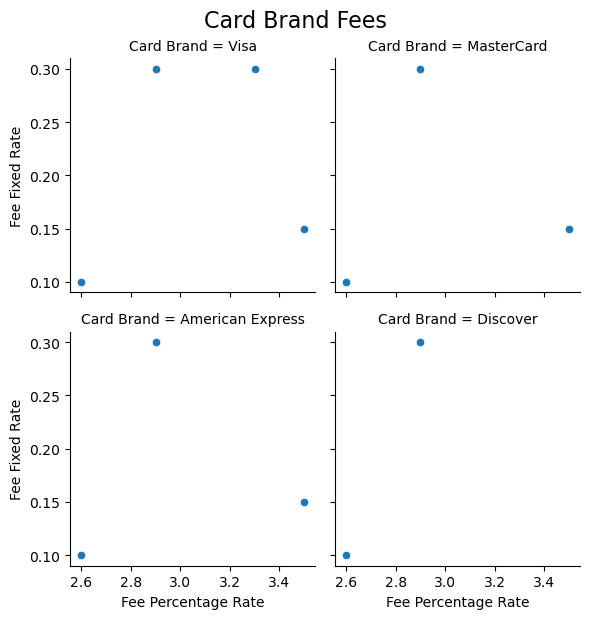

In [180]:
# Visualize relationship between card brands and fees

g = sns.relplot(
    x='Fee Percentage Rate',
    y='Fee Fixed Rate',
    kind='scatter',
    col='Card Brand',
    col_wrap=2,
    data=complete_trans,
    height=3
)

g.figure.suptitle('Card Brand Fees', fontsize=16, y=1.025)
plt.show()

In [175]:
# Select rows with a fee percentage of 2.6

complete_trans[complete_trans['Fee Percentage Rate'] == 2.6].head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
0,2023-11-27,2025-01-02 18:11:12,10.89,0.0,0.0,10.89,0.00,0.0,0.0,10.89,Point of Sale,10.89,Tapped,0.0,0.0,NaN,-0.38,10.51,sMznCMvA9sG5OwWqBdnWvg3eV,7pgJeys0KWsK5IGLFYCo8fafuaB,Visa,5728.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"French fries (Rosemary, Side), Pineapple Coles...",Payment,For Here,4GBWG86RY6TE2YMWR0JN7S0XQC,Emily Samvalian,0.0,3ZQ9S0C1TFZ91SK87PZJCAJYSX1N,2023-11-29,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN
14,2023-12-31,2025-01-02 17:42:54,115.07,0.0,0.0,115.07,10.93,0.0,0.0,126.00,Point of Sale,126.00,Tapped,0.0,0.0,NaN,-3.38,122.62,UiMrcBvXQpdYgw9Uv6rANFqeV,T5eHErUi2fuJiAQXLlQnAsXEuaB,American Express,2007.0,Vartan,https://app.squareup.com/dashboard/sales/trans...,"BELLY SLIDERS (6 sliders) - Tender, glazed por...",Payment,For Here,Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,0.0,3Z561QY9TAVX7ZF8E5VPVY0TA0RX,2023-12-31,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN
20,2024-01-05,2025-01-02 15:35:32,51.44,0.0,0.0,51.44,4.89,0.0,0.0,56.33,Point of Sale,56.33,Tapped,0.0,0.0,NaN,-1.56,54.77,4EMJZdahqZfatjRKjlwQBveeV,bNEInqDuctA3ZTwhtPcQpaFFuaB,Visa,7360,Vartan,https://app.squareup.com/dashboard/sales/trans...,"3 x BELLY SLIDERS (2 sliders) - Tender, glazed...",Payment,For Here,NaN,NaN,0.0,3Z4ST23PFWYS0GKCFY77HPP9RDXD,2024-01-05,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN
21,2024-01-06,2025-01-02 16:55:10,150.69,0.0,0.0,150.69,11.09,0.0,0.0,161.78,Point of Sale,161.78,Tapped,0.0,0.0,NaN,-4.31,157.47,MoXsNI8XlPrEoaSlJzqXWMveV,D7ZAXTRQF7v7NmILYNAjNLdtvaB,American Express,2007,Vartan,https://app.squareup.com/dashboard/sales/trans...,"5 x BELLY SLIDERS (4 sliders) - Tender, glazed...",Payment,"Pick Up, For Here",Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,0.0,3ZSKE8Z3R0MH4RX8766CH6KGQWNS,2024-01-06,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN
22,2024-01-06,2025-01-02 16:55:31,26.98,0.0,0.0,26.98,2.56,0.0,0.0,29.54,Point of Sale,29.54,Tapped,0.0,0.0,NaN,-0.87,28.67,mfYUKul1XGJLREel7lqabMveV,HdLB7BtsEoiXMSeoOhB8kZAJuaB,American Express,2007,Vartan,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Half rack) - Juicy, succu...",Payment,Pick Up,Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,0.0,3Z6KXRD5REVH3ZQCR0MM2HMA1AWS,2024-01-06,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN


In [203]:
# Select rows with a fee percentage of 6

fee_percentage_outlier = complete_trans[complete_trans['Fee Percentage Rate'] == 6]
fee_percentage_outlier

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
685,2024-11-28,2025-01-02 11:35:12,164.9,0.0,0.0,164.9,15.67,16.49,0.0,197.06,Square Online,0.0,NaN,0.0,0.0,NaN,-12.12,184.94,K6PTeYGwKcbNE6surrOzg3bN9AWZY,RavL88a9PGCa3dobdLzu2YoYSGIZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,Party Package (6-8 ppl) (Regular) - Save your ...,Payment,NaN,HQ0N2BCBBTZ37M7BRND0B281J0,Brisseida Candelaria,0.0,3Z7HJZ2CM1S13HBC98QYE87F51P9,2024-11-28,https://app.squareup.com/dashboard/sales/depos...,6.0,0.3,Complete,11efad40cf1ca149bd5e3cecef6dbaf0


In [185]:
# Visualize fees grouped by transaction source

complete_trans.groupby(by='Source')[['Fee Percentage Rate', 'Fee Fixed Rate']].value_counts()

Source                  Fee Percentage Rate  Fee Fixed Rate
Invoices                3.3                  0.30                1
Payment Link            2.9                  0.30                8
Point of Sale           2.6                  0.10              102
                        3.5                  0.15               22
                        2.9                  0.30                6
Square Online           2.9                  0.30              142
                        6.0                  0.30                1
Virtual Terminal        3.5                  0.15                1
eCommerce Integrations  2.9                  0.30                1
Name: count, dtype: int64

In [ ]:
# Select transactions made through the pos system with a fee percentage of 3.5

pos_higher = complete_trans[(complete_trans['Source'] == 'Point of Sale') & (complete_trans['Fee Percentage Rate'] == 3.5)].head()
pos_higher.head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
198,2024-06-05,2025-01-02 19:50:41,34.10,0.0,0.0,34.10,3.24,0.0,0.0,37.34,Point of Sale,37.34,Keyed,0.0,0.0,NaN,-1.46,35.88,QiTw9zmUv8Ef3ffpm55k4UseV,Vmy0vlFGx60U2TPNNgmJ2Sd1vaB,MasterCard,2195,Dashboard Belly Rubb,https://app.squareup.com/dashboard/sales/trans...,"CHICKEN WINGS (6 pcs) - Juicy and Crispy, tota...",Payment,Pick Up,WCS1A47C053490N4C24WHT466C,Troy Issac,0.0,3ZRWEKSPTQP10WK7327H6YFMHV29,2024-06-05,https://app.squareup.com/dashboard/sales/depos...,3.5,0.15,Complete,NaN
200,2024-06-06,2025-01-02 17:35:44,72.33,0.0,0.0,72.33,6.87,0.0,0.0,79.20,Point of Sale,79.20,Keyed,0.0,0.0,NaN,-2.92,76.28,Ii1eOogyCdj7Feqo03p9gF0eV,DzvLSRVScl0rpO4pffzneCqjvaB,MasterCard,2195,Dashboard Belly Rubb,https://app.squareup.com/dashboard/sales/trans...,STEAK SANDWICH COMBO (Regular) - This combo is...,Payment,Delivery,WCS1A47C053490N4C24WHT466C,Troy Issac,0.0,3ZRBAX41S9FX06H3C6B22F71BX4N,2024-06-06,https://app.squareup.com/dashboard/sales/depos...,3.5,0.15,Complete,NaN
232,2024-06-25,2025-01-02 14:26:45,106.65,0.0,0.0,106.65,10.13,5.0,0.0,121.78,Point of Sale,121.78,Keyed,0.0,0.0,NaN,-4.41,117.37,QoOsLuoVX2OX1i2Wk4NW5OleV,dMbgtqa70JUPxL1yuJgGKH1suaB,MasterCard,4467,Dashboard Belly Rubb,https://app.squareup.com/dashboard/sales/trans...,"STEAK SANDWICH COMBO (Regular), STEAK SANDWICH...",Payment,Pick Up,NaN,NaN,0.0,3ZX10B5J2S6H4WZ5JBM2487K9CZN,2024-06-25,https://app.squareup.com/dashboard/sales/depos...,3.5,0.15,Complete,NaN
313,2024-08-02,2025-01-02 14:36:02,91.05,0.0,0.0,91.05,8.65,0.0,0.0,99.70,Point of Sale,99.70,Keyed,0.0,0.0,NaN,-3.64,96.06,kGMEYrDf5CBMcr2P3brewkxeV,Ra50qSUebVybzTCCyw15JzCCuaB,Visa,6261,Dashboard Belly Rubb,https://app.squareup.com/dashboard/sales/trans...,CIABATTA STEAK SANDWICH (Regular) - Slow-cooke...,Payment,Pick Up,NaN,NaN,0.0,3ZS81H8KGD7H3XVBXBCX07ZKWRE1,2024-08-02,https://app.squareup.com/dashboard/sales/depos...,3.5,0.15,Complete,NaN
316,2024-08-03,2025-01-02 16:17:45,23.98,0.0,0.0,23.98,2.28,0.0,0.0,26.26,Point of Sale,26.26,Keyed,0.0,0.0,NaN,-1.07,25.19,UDf6SadTaf2A3dNODASFxljmR0VZY,BoKNDrtty6YoGem2vkvwDTwHsP8YY,Visa,9992,Vartan’s iPad,https://app.squareup.com/dashboard/sales/trans...,"BABY BACK RIB COMBO (Regular) - Flying solo, o...",Payment,Pick Up,PRJ1E735VK59SJ4J0AVM21YJ4G,NaN,0.0,3ZTK52NA4DQX5WZDCFBGC89GY7NH,2024-08-03,https://app.squareup.com/dashboard/sales/depos...,3.5,0.15,Complete,NaN


In [ ]:
# Select transactions made through the pos system with a fee percentage of 2.6

pos_lower = complete_trans[(complete_trans['Source'] == 'Point of Sale') & (complete_trans['Fee Percentage Rate'] == 2.6)].head()
pos_lower.head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
0,2023-11-27,2025-01-02 18:11:12,10.89,0.0,0.0,10.89,0.00,0.0,0.0,10.89,Point of Sale,10.89,Tapped,0.0,0.0,NaN,-0.38,10.51,sMznCMvA9sG5OwWqBdnWvg3eV,7pgJeys0KWsK5IGLFYCo8fafuaB,Visa,5728.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"French fries (Rosemary, Side), Pineapple Coles...",Payment,For Here,4GBWG86RY6TE2YMWR0JN7S0XQC,Emily Samvalian,0.0,3ZQ9S0C1TFZ91SK87PZJCAJYSX1N,2023-11-29,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN
14,2023-12-31,2025-01-02 17:42:54,115.07,0.0,0.0,115.07,10.93,0.0,0.0,126.00,Point of Sale,126.00,Tapped,0.0,0.0,NaN,-3.38,122.62,UiMrcBvXQpdYgw9Uv6rANFqeV,T5eHErUi2fuJiAQXLlQnAsXEuaB,American Express,2007.0,Vartan,https://app.squareup.com/dashboard/sales/trans...,"BELLY SLIDERS (6 sliders) - Tender, glazed por...",Payment,For Here,Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,0.0,3Z561QY9TAVX7ZF8E5VPVY0TA0RX,2023-12-31,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN
20,2024-01-05,2025-01-02 15:35:32,51.44,0.0,0.0,51.44,4.89,0.0,0.0,56.33,Point of Sale,56.33,Tapped,0.0,0.0,NaN,-1.56,54.77,4EMJZdahqZfatjRKjlwQBveeV,bNEInqDuctA3ZTwhtPcQpaFFuaB,Visa,7360,Vartan,https://app.squareup.com/dashboard/sales/trans...,"3 x BELLY SLIDERS (2 sliders) - Tender, glazed...",Payment,For Here,NaN,NaN,0.0,3Z4ST23PFWYS0GKCFY77HPP9RDXD,2024-01-05,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN
21,2024-01-06,2025-01-02 16:55:10,150.69,0.0,0.0,150.69,11.09,0.0,0.0,161.78,Point of Sale,161.78,Tapped,0.0,0.0,NaN,-4.31,157.47,MoXsNI8XlPrEoaSlJzqXWMveV,D7ZAXTRQF7v7NmILYNAjNLdtvaB,American Express,2007,Vartan,https://app.squareup.com/dashboard/sales/trans...,"5 x BELLY SLIDERS (4 sliders) - Tender, glazed...",Payment,"Pick Up, For Here",Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,0.0,3ZSKE8Z3R0MH4RX8766CH6KGQWNS,2024-01-06,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN
22,2024-01-06,2025-01-02 16:55:31,26.98,0.0,0.0,26.98,2.56,0.0,0.0,29.54,Point of Sale,29.54,Tapped,0.0,0.0,NaN,-0.87,28.67,mfYUKul1XGJLREel7lqabMveV,HdLB7BtsEoiXMSeoOhB8kZAJuaB,American Express,2007,Vartan,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Half rack) - Juicy, succu...",Payment,Pick Up,Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,0.0,3Z6KXRD5REVH3ZQCR0MM2HMA1AWS,2024-01-06,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN


In [191]:
pos_higher['Card Entry Methods'].unique()

array(['Keyed'], dtype=object)

In [192]:
pos_lower['Card Entry Methods'].unique()

array(['Tapped'], dtype=object)

In [197]:
# Select transactions made through the pos system with a fixed fee of 0.3

pos_highest = complete_trans[(complete_trans['Fee Fixed Rate'] == 0.30) & (complete_trans['Source'] == 'Point of Sale')]
pos_highest.head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
5,2023-12-09,2025-01-02 14:29:54,-74.10,0.0,0.0,-74.10,-7.04,-14.82,0.0,-95.96,Point of Sale,-95.96,Keyed,0.0,0.0,NaN,0.0,-95.96,uVh61UleK3NqFaLKt9YpWG2eV,bLxBY8QZHfkvM78ktCGQp9E5g6WZY,MasterCard,299.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Full Rack) - Juicy, succu...",Refund,NaN,NaN,NaN,0.0,3Z7CHTKRCQWX0Y711HZ9C4C2F2A5,2023-12-09,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,NaN
28,2024-01-13,2025-01-02 16:37:51,-3.40,0.0,0.0,-3.40,-0.32,0.00,0.0,-3.72,Point of Sale,-3.72,Keyed,0.0,0.0,NaN,0.0,-3.72,U6O66BMqEfT2edsSxK8g9u7eV,F6uzFIYjwUTmCTE75SAesNpG7FSZY,Visa,2991,NaN,https://app.squareup.com/dashboard/sales/trans...,2 x SWEET AND SPICY BBQ SAUCE (Regular) - Our ...,Refund,NaN,NaN,NaN,0.0,3ZN2KRAPF1JD2NZ5MBKFQEA2AGB1,2024-01-13,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,NaN
438,2024-09-17,2025-01-02 18:45:47,-11.36,0.0,0.0,-11.36,-1.08,0.00,0.0,-12.44,Point of Sale,-12.44,Keyed,0.0,0.0,NaN,0.0,-12.44,ASRV5i3668kS0ysYMyA6WTzeV,N6eOATZenV6HLXy9ejVLWsDZQ1cZY,Visa,3957,NaN,https://app.squareup.com/dashboard/sales/trans...,"MOZZARELLA STICKS (6 pcs) - Flavorful, deep fr...",Refund,NaN,NaN,NaN,0.0,3Z8P65TQ8C6N3PZ7B4BJSF83GWDN,2024-09-17,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,NaN
441,2024-09-17,2025-01-02 17:30:55,-27.52,0.0,0.0,-27.52,-2.61,0.00,0.0,-30.13,Point of Sale,-30.13,Keyed,0.0,0.0,NaN,0.0,-30.13,EYFwyqZFRNxQ7ey3GPJ1PGjeV,N6eOATZenV6HLXy9ejVLWsDZQ1cZY,Visa,3957,NaN,https://app.squareup.com/dashboard/sales/trans...,2 x BELLY SLIDERS (2 sliders) - Impossibly ten...,Refund,NaN,NaN,NaN,0.0,3ZRQCESHNKWN5AD9J9794YF0NZGX,2024-09-17,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,NaN
444,2024-09-17,2025-01-02 12:46:39,-16.98,1.7,0.0,-15.28,-1.45,0.00,0.0,-16.73,Point of Sale,-16.73,Keyed,0.0,0.0,NaN,0.0,-16.73,kU5bo8ahS8D0waTRM51fBe4eV,tSqWMQVZyv8yH1tGALDs55GUDiAZY,Visa,9304,NaN,https://app.squareup.com/dashboard/sales/trans...,"2 x BELLY BITES (4 Bites) - Four bite-sized, t...",Refund,NaN,NaN,NaN,0.0,3ZNHYWVFJX6S09S17CCXPPCE2RQH,2024-09-17,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,NaN


In [198]:
pos_highest['Card Entry Methods'].unique()

array(['Keyed'], dtype=object)

In [199]:
pos_higher.describe()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Card,Cash,Other Tender,Fees,Net Total,Third Party Fees,Fee Percentage Rate,Fee Fixed Rate
count,5,5,5.000000,5.0,5.0,5.000000,5.000000,5.000000,5.0,5.0000,5.0000,5.0,5.0,5.000000,5.000000,5.0,5.0,5.00
mean,2024-07-02 14:24:00,2025-01-02 16:33:23.400000,65.622000,0.0,0.0,65.622000,6.234000,1.000000,0.0,72.8560,72.8560,0.0,0.0,-2.700000,70.156000,0.0,3.5,0.15
min,2024-06-05 00:00:00,2025-01-02 14:26:45,23.980000,0.0,0.0,23.980000,2.280000,0.000000,0.0,26.2600,26.2600,0.0,0.0,-4.410000,25.190000,0.0,3.5,0.15
25%,2024-06-06 00:00:00,2025-01-02 14:36:02,34.100000,0.0,0.0,34.100000,3.240000,0.000000,0.0,37.3400,37.3400,0.0,0.0,-3.640000,35.880000,0.0,3.5,0.15
50%,2024-06-25 00:00:00,2025-01-02 16:17:45,72.330000,0.0,0.0,72.330000,6.870000,0.000000,0.0,79.2000,79.2000,0.0,0.0,-2.920000,76.280000,0.0,3.5,0.15
75%,2024-08-02 00:00:00,2025-01-02 17:35:44,91.050000,0.0,0.0,91.050000,8.650000,0.000000,0.0,99.7000,99.7000,0.0,0.0,-1.460000,96.060000,0.0,3.5,0.15
max,2024-08-03 00:00:00,2025-01-02 19:50:41,106.650000,0.0,0.0,106.650000,10.130000,5.000000,0.0,121.7800,121.7800,0.0,0.0,-1.070000,117.370000,0.0,3.5,0.15
std,NaN,NaN,35.716137,0.0,0.0,35.716137,3.391848,2.236068,0.0,40.5801,40.5801,0.0,0.0,1.418679,39.161421,0.0,0.0,0.00


In [200]:
pos_highest.describe()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Card,Cash,Other Tender,Fees,Net Total,Third Party Fees,Fee Percentage Rate,Fee Fixed Rate
count,6,6,6.000000,6.000000,6.0,6.000000,6.000000,6.00000,6.000000,6.000000,6.000000,6.0,6.0,6.0,6.000000,6.0,6.0,6.0
mean,2024-07-02 20:00:00,2025-01-02 15:58:14.333333504,-22.226667,0.283333,0.0,-21.943333,-2.083333,-2.47000,-14.176667,-40.673333,-40.673333,0.0,0.0,0.0,-40.673333,0.0,2.9,0.3
min,2023-12-09 00:00:00,2025-01-02 12:46:39,-74.100000,0.000000,0.0,-74.100000,-7.040000,-14.82000,-85.060000,-95.960000,-95.960000,0.0,0.0,0.0,-95.960000,0.0,2.9,0.3
25%,2024-03-15 00:00:00,2025-01-02 14:47:00.500000,-24.885000,0.000000,0.0,-24.460000,-2.320000,0.00000,0.000000,-71.327500,-71.327500,0.0,0.0,0.0,-71.327500,0.0,2.9,0.3
50%,2024-09-17 00:00:00,2025-01-02 16:08:05.500000,-14.170000,0.000000,0.0,-13.320000,-1.265000,0.00000,0.000000,-23.430000,-23.430000,0.0,0.0,0.0,-23.430000,0.0,2.9,0.3
75%,2024-09-17 00:00:00,2025-01-02 17:17:39,-5.390000,0.000000,0.0,-5.390000,-0.510000,0.00000,0.000000,-13.512500,-13.512500,0.0,0.0,0.0,-13.512500,0.0,2.9,0.3
max,2024-11-30 00:00:00,2025-01-02 18:45:47,0.000000,1.700000,0.0,0.000000,0.000000,0.00000,0.000000,-3.720000,-3.720000,0.0,0.0,0.0,-3.720000,0.0,2.9,0.3
std,NaN,NaN,27.250476,0.694022,0.0,27.324674,2.596279,6.05024,34.725600,39.683515,39.683515,0.0,0.0,0.0,39.683515,0.0,0.0,0.0


In [201]:
pos_highest['Event Type'].unique()

array(['Refund'], dtype=object)

In [202]:
pos_higher['Event Type'].unique()

array(['Payment'], dtype=object)

In [204]:
# Select transaction with a fee percentage rate of 6

fee_percentage_outlier

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
685,2024-11-28,2025-01-02 11:35:12,164.9,0.0,0.0,164.9,15.67,16.49,0.0,197.06,Square Online,0.0,NaN,0.0,0.0,NaN,-12.12,184.94,K6PTeYGwKcbNE6surrOzg3bN9AWZY,RavL88a9PGCa3dobdLzu2YoYSGIZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,Party Package (6-8 ppl) (Regular) - Save your ...,Payment,NaN,HQ0N2BCBBTZ37M7BRND0B281J0,Brisseida Candelaria,0.0,3Z7HJZ2CM1S13HBC98QYE87F51P9,2024-11-28,https://app.squareup.com/dashboard/sales/depos...,6.0,0.3,Complete,11efad40cf1ca149bd5e3cecef6dbaf0


In [206]:
# Check for other orders by this customer

trans_df[trans_df['Customer ID'] == 'HQ0N2BCBBTZ37M7BRND0B281J0']

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
685,2024-11-28,2025-01-02 11:35:12,164.9,0.0,0.0,164.9,15.67,16.49,0.0,197.06,Square Online,0.0,NaN,0.0,0.0,NaN,-12.12,184.94,K6PTeYGwKcbNE6surrOzg3bN9AWZY,RavL88a9PGCa3dobdLzu2YoYSGIZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,Party Package (6-8 ppl) (Regular) - Save your ...,Payment,NaN,HQ0N2BCBBTZ37M7BRND0B281J0,Brisseida Candelaria,0.0,3Z7HJZ2CM1S13HBC98QYE87F51P9,2024-11-28,https://app.squareup.com/dashboard/sales/depos...,6.0,0.3,Complete,11efad40cf1ca149bd5e3cecef6dbaf0


This is an outlier row which does not include any information on the form of payment. 

In [219]:
# Extract items ordered from outlier

fee_percentage_outlier_description = fee_percentage_outlier['Description'].values
fee_percentage_outlier_description[0]

'Party Package (6-8 ppl) (Regular) - Save your time and money!\nHere is our party deal:\nGLAZED BABY BACK PORK RIBS (full slab) x 2\nChicken Wings x 18\nMac&Cheese(Full) x2\nPineapple Slaw(Full) x1\nGrilled sweet corn x5\nCrinkle Fries (Full) x2, CLASSY RANCH DIP (Regular) - Enjoy our classic Ranch Dipping Sauce, a creamy blend of buttermilk, herbs and spices, perfect for dipping fries or wings., SWEET AND SPICY BBQ DIP (Regular) - Our unbeatable classic with a smoky and spicy twist. Perfectly pairs with pork meat and chicken wings.\n\n\n\n\n\n\n\n\n*ALLERGEN WARNING* May contain seafood'

In [220]:
# Find other transactions with same order

trans_df[trans_df['Description'] == fee_percentage_outlier_description[0]]

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
685,2024-11-28,2025-01-02 11:35:12,164.9,0.0,0.0,164.9,15.67,16.49,0.0,197.06,Square Online,0.0,NaN,0.0,0.0,NaN,-12.12,184.94,K6PTeYGwKcbNE6surrOzg3bN9AWZY,RavL88a9PGCa3dobdLzu2YoYSGIZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,Party Package (6-8 ppl) (Regular) - Save your ...,Payment,NaN,HQ0N2BCBBTZ37M7BRND0B281J0,Brisseida Candelaria,0.0,3Z7HJZ2CM1S13HBC98QYE87F51P9,2024-11-28,https://app.squareup.com/dashboard/sales/depos...,6.0,0.3,Complete,11efad40cf1ca149bd5e3cecef6dbaf0


In [226]:
# Find other transactions with same party platter order

trans_df[trans_df['Description'].str.contains('Party Package (6-8 ppl)', case=False, regex=False)]

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
346,2024-08-15,2025-01-02 11:38:15,162.00,0.0,0.0,162.00,14.92,0.00,0.0,176.92,DOORDASH,0.00,NaN,0.0,176.92,DoorDash 81ce18d2-8011-3001-b77b-87034b79f891,0.00,176.92,MtYTIrj9R8Im0DAxgHnCNp1Z3TXZY,lqEWhGAEluyQRAhP9jLK44udBR6YY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,Party Package (6-8 ppl) (Regular) - Save your ...,Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,09764ce0-9fad-465f-8ab8-3bc553bd7a13
610,2024-11-08,2025-01-02 19:29:09,203.82,0.0,0.0,203.82,19.36,0.00,0.0,223.18,Point of Sale,223.18,Keyed,0.0,0.00,NaN,-7.96,215.22,CGLjhu1K9J0RrAVPWKcHDnI97gFZY,FCgCDz1qnUhN1WHSdBfkIM1n7rOZY,MasterCard,0168,Dashboard Belly Rubb,https://app.squareup.com/dashboard/sales/trans...,Party Package (6-8 ppl) (Regular) - Save your ...,Payment,Pick Up,NaN,NaN,0.0,3ZMYBNNEP87N12K8Q4MY0QJ2KFKH,2024-11-08,https://app.squareup.com/dashboard/sales/depos...,3.5,0.15,Complete,NaN
685,2024-11-28,2025-01-02 11:35:12,164.90,0.0,0.0,164.90,15.67,16.49,0.0,197.06,Square Online,0.00,NaN,0.0,0.00,NaN,-12.12,184.94,K6PTeYGwKcbNE6surrOzg3bN9AWZY,RavL88a9PGCa3dobdLzu2YoYSGIZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,Party Package (6-8 ppl) (Regular) - Save your ...,Payment,NaN,HQ0N2BCBBTZ37M7BRND0B281J0,Brisseida Candelaria,0.0,3Z7HJZ2CM1S13HBC98QYE87F51P9,2024-11-28,https://app.squareup.com/dashboard/sales/depos...,6.0,0.30,Complete,11efad40cf1ca149bd5e3cecef6dbaf0
696,2024-11-28,2025-01-02 12:52:34,162.00,0.0,0.0,162.00,15.39,0.00,0.0,177.39,Square Online,177.39,Keyed,0.0,0.00,NaN,-5.44,171.95,wLaTvo6wsOOGMHLvtndOgRL7t8UZY,pkg4ycdtIciAKWHQjj1ruC1CPEAZY,Visa,0419,NaN,https://app.squareup.com/dashboard/sales/trans...,Party Package (6-8 ppl) (Regular) - Save your ...,Payment,NaN,AD1G8TZPTW8AE2TDD64XPGEYD8,Janet Figueroa,0.0,3ZT9GDQRBTCN6NZAZJX57EAEA5R9,2024-11-28,https://app.squareup.com/dashboard/sales/depos...,2.9,0.30,Complete,11efadca0a8729abbd5e3cecef6dbaf0


##### Conclusions
- Transactions where the card information was keyed in have a *higher* fee percentage of 3.5 and fixed fee rate of 0.15. Transactions where the card was physically tapped have a *lower* fee percentage of 2.6 and fixed fee rate of 0.1. 
- Refunds made through the POS system are charged a fee percentage rate of 2.9 and fixed rate of 0.3.
- There is one transaction with a fee percentage rate of 6. This is much higher than any of the others.
  - There is no discovered relationship between a fee percentage of 6 and other features. Transaction with ID K6PTeYGwKcbNE6surrOzg3bN9AWZY is an outlier with no valuable information



### Customer ID, Name and Deposit, Fee

There is a correlation in missingness between customer ID and Name, and Deposit details, fees, and Card information.

In [234]:
# Extract transactions with a customer name saved

name_not_null = complete_trans[complete_trans['Customer Name'].notnull()]
name_not_null.head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
0,2023-11-27,2025-01-02 18:11:12,10.89,0.0,0.0,10.89,0.00,0.00,0.0,10.89,Point of Sale,10.89,Tapped,0.0,0.0,NaN,-0.38,10.51,sMznCMvA9sG5OwWqBdnWvg3eV,7pgJeys0KWsK5IGLFYCo8fafuaB,Visa,5728.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"French fries (Rosemary, Side), Pineapple Coles...",Payment,For Here,4GBWG86RY6TE2YMWR0JN7S0XQC,Emily Samvalian,0.0,3ZQ9S0C1TFZ91SK87PZJCAJYSX1N,2023-11-29,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN
3,2023-12-05,2025-01-02 16:12:32,44.16,0.0,0.0,44.16,4.20,0.00,0.0,48.36,Square Online,48.36,Keyed,0.0,0.0,NaN,-1.70,46.66,85Ohwx4gPrfiynZJjKgKeJ7k7POZY,FMr15YGavlmjOm2GSxZZJGYwZEWZY,MasterCard,9004.0,NaN,https://app.squareup.com/dashboard/sales/trans...,2 x MAC&CHEESE (8 oz.) - Here’s to taking the ...,Payment,NaN,TQR1MWV3DD53N64TY1FT5YEHP0,Alissa Khachmanyan,0.0,3ZVW7JKH4ZJ10EF4D9BDJ4AJ7TEH,2023-12-05,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,11ee93cbd6b99b0caf423cecef6dbaf0
4,2023-12-07,2025-01-02 12:44:33,28.98,0.0,0.0,28.98,2.75,5.80,0.0,37.53,Square Online,37.53,Keyed,0.0,0.0,NaN,-1.39,36.14,EDn6LPZxDq4Md7Th98OE0TQ4Q1GZY,1qsC2RdR9JBEiLBNxsXLJNKQVUNZY,Visa,5658.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Half rack) - Juicy, succu...",Payment,NaN,Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,0.0,3ZSM1F1BGKWS4Q37A590QHYGH655,2023-12-07,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,11ee9541284203e6af423cecef6dbaf0
6,2023-12-09,2025-01-02 13:19:42,74.10,0.0,0.0,74.10,7.04,14.82,0.0,95.96,Square Online,95.96,Keyed,0.0,0.0,NaN,-3.08,92.88,EdI6bYmV3RObEJPKCymrNv6EIQLZY,bLxBY8QZHfkvM78ktCGQp9E5g6WZY,MasterCard,299.0,NaN,https://app.squareup.com/dashboard/sales/trans...,THE BABY BACK COMBO (Crinkle Fries- Rosemary P...,Payment,NaN,0BGYJMQ4GZT0VTE3D98AE51TER,Arus Keshishyan,0.0,3ZVRCC2PGJN57D3BP3H1GXA5CW1H,2023-12-09,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,11ee96d8028fa2aaaf423cecef6dbaf0
7,2023-12-13,2025-01-02 17:08:37,86.84,0.0,0.0,86.84,8.25,13.03,0.0,108.12,Square Online,108.12,Keyed,0.0,0.0,NaN,-3.44,104.68,0pua7lQamI5CCtUq43TmHXo7jU8YY,LZgdp6gejId2tUMC8G3Te4tpsFSZY,Visa,6175.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"2 x GET YOUR BABY BACK! (Full Rack) - Juicy, s...",Payment,NaN,WG8AZ9EW89CN9JZKY5GPEWKT6W,Michael Keshishyan,0.0,3Z5DQPF6Y1C5409AS1X8CBYJESM9,2023-12-13,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,11ee9a1ce887aac3af423cecef6dbaf0


In [235]:
# Extract transactions with customer name missing

name_null = complete_trans[complete_trans['Customer Name'].isnull()]
name_null.head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
1,2023-11-27,2025-01-02 13:37:08,88.56,0.0,0.0,88.56,0.00,0.00,0.0,88.56,Point of Sale,0.00,NaN,88.56,0.00,NaN,0.0,88.56,GRjFkwdOFJlIXYiHIP6XwNoeV,fTEPnGM8IqeBWDl65MPdzEtRvaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,2 x “Get your baby back” Pork Ribs (Full Rack)...,Payment,Pick Up,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,NaN
5,2023-12-09,2025-01-02 14:29:54,-74.10,0.0,0.0,-74.10,-7.04,-14.82,0.0,-95.96,Point of Sale,-95.96,Keyed,0.00,0.00,NaN,0.0,-95.96,uVh61UleK3NqFaLKt9YpWG2eV,bLxBY8QZHfkvM78ktCGQp9E5g6WZY,MasterCard,299.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Full Rack) - Juicy, succu...",Refund,NaN,NaN,NaN,0.0,3Z7CHTKRCQWX0Y711HZ9C4C2F2A5,2023-12-09,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,NaN
10,2023-12-28,2025-01-02 13:10:12,9.34,0.0,0.0,9.34,0.89,0.00,0.0,10.23,DOORDASH,0.00,NaN,0.00,10.23,DoorDash 32511734-9c22-3001-85cd-9fa25d985929,0.0,10.23,G8NtqxpsCGVw3ZYlOPLHKyBjhJIZY,xGDUfOjmaBMmbGWAkpO9Ba3xrDSZY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,"CRINKLE FRIES (Full, Truffle salt) - Golden, c...",Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,09884d10-ac90-401c-9333-640b45fb3ad5
12,2023-12-30,2025-01-02 15:29:25,53.40,0.0,0.0,53.40,4.31,0.00,0.0,57.71,DOORDASH,0.00,NaN,0.00,57.71,DoorDash 4201350b-a048-407c-b448-026314821e3d,0.0,57.71,2yCSwAHZecEBnU0UjxHAC9cLFmLZY,fXGzLpFcKyqzD2BiXsA1c2UtN09YY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,"BELLY SLIDERS (4 sliders) - Tender, glazed por...",Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,4644fd4e-ae1e-4057-9c63-807e034f4611
15,2024-01-03,2025-01-02 14:04:45,24.84,0.0,0.0,24.84,2.36,0.00,0.0,27.20,DOORDASH,0.00,NaN,0.00,27.20,DoorDash f51e9461-94b1-405c-9b67-739d4897841f,0.0,27.20,wVP7Hej4tBfoa5qu8yuOwe7xGNQZY,jB02AoC0BQAdzXbhMUTzXPvdA48YY,NaN,NaN,NaN,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Half rack) - Juicy, succu...",Payment,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,8a8fc68b-85de-41d0-8263-82abe3b868f4


In [236]:
# Summarize transactions with a customer name

name_not_null.describe()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Card,Cash,Other Tender,Fees,Net Total,Third Party Fees,Fee Percentage Rate,Fee Fixed Rate
count,214,214,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.0,214.000000,214.000000,214.000000,214.0,214.000000,214.000000,214.000000,194.000000,194.000000
mean,2024-07-30 01:47:39.813084160,2025-01-02 15:07:47.598130688,69.172150,-0.180234,0.958832,68.991916,6.317991,2.946121,0.0,78.256028,69.631355,7.703832,0.0,-3.799579,74.456449,1.488738,2.890206,0.258763
min,2023-11-27 00:00:00,2025-01-02 07:04:49,0.990000,-5.980000,0.000000,0.990000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,-59.000000,0.870000,0.000000,2.600000,0.100000
25%,2024-05-30 06:00:00,2025-01-02 12:41:36,27.860000,0.000000,0.000000,27.567500,2.465000,0.000000,0.0,30.575000,25.017500,0.000000,0.0,-2.865000,29.250000,0.000000,2.900000,0.300000
50%,2024-08-13 00:00:00,2025-01-02 15:23:31.500000,46.710000,0.000000,0.000000,46.200000,4.220000,0.000000,0.0,53.640000,47.815000,0.000000,0.0,-1.660000,47.740000,0.000000,2.900000,0.300000
75%,2024-10-24 00:00:00,2025-01-02 17:44:16,72.187500,0.000000,0.000000,72.187500,6.560000,4.720000,0.0,80.290000,77.720000,0.000000,0.0,-0.960000,77.030000,0.000000,2.900000,0.300000
max,2024-12-19 00:00:00,2025-01-02 22:33:55,1039.950000,0.000000,35.800000,1039.950000,98.800000,21.130000,0.0,1158.750000,1158.750000,392.390000,0.0,0.000000,1124.850000,46.290000,6.000000,0.300000
std,NaN,NaN,96.307716,0.829615,3.926080,96.363691,8.981958,4.532724,0.0,107.355416,106.855387,33.862066,0.0,6.909877,103.618821,5.575223,0.285136,0.079183


In [237]:
# Summarize transactions with a missing customer name

name_null.describe()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Card,Cash,Other Tender,Fees,Net Total,Third Party Fees,Fee Percentage Rate,Fee Fixed Rate
count,517,517,517.000000,517.000000,517.0,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.0,90.000000,90.000000
mean,2024-08-09 01:04:03.713732864,2025-01-02 16:27:12.021276672,46.688008,-0.015164,0.0,46.672843,4.180464,0.061044,-0.196325,50.718027,9.115957,4.818395,36.783675,-0.266190,50.451838,0.0,2.773333,0.123889
min,2023-11-27 00:00:00,2025-01-02 00:05:39,-358.350000,-5.000000,0.0,-358.350000,-34.040000,-14.820000,-85.060000,-392.390000,-95.960000,-392.390000,-88.730000,-10.050000,-392.390000,0.0,2.600000,0.100000
25%,2024-06-07 00:00:00,2025-01-02 14:10:13,25.430000,0.000000,0.0,25.430000,2.300000,0.000000,0.000000,27.750000,0.000000,0.000000,0.000000,0.000000,27.680000,0.0,2.600000,0.100000
50%,2024-09-05 00:00:00,2025-01-02 16:57:58,38.950000,0.000000,0.0,38.950000,3.420000,0.000000,0.000000,42.230000,0.000000,0.000000,33.610000,0.000000,41.950000,0.0,2.600000,0.100000
75%,2024-10-31 00:00:00,2025-01-02 18:52:59,57.860000,0.000000,0.0,57.860000,5.220000,0.000000,0.000000,63.020000,0.000000,0.000000,54.110000,0.000000,62.980000,0.0,2.600000,0.100000
max,2024-12-20 00:00:00,2025-01-02 22:58:24,444.850000,1.700000,0.0,444.850000,42.260000,25.000000,0.000000,487.110000,282.730000,352.040000,487.110000,15.490000,487.110000,0.0,3.500000,0.300000
std,NaN,NaN,43.573292,0.306211,0.0,43.562420,4.070094,1.363200,3.801295,48.084205,29.534044,29.451998,41.079553,1.150028,47.767781,0.0,0.336472,0.054684


Looks like transactions with a null name have a lower mean *card* amount than transactions without a null name. This could mean that the names of customers paying with card are saved.

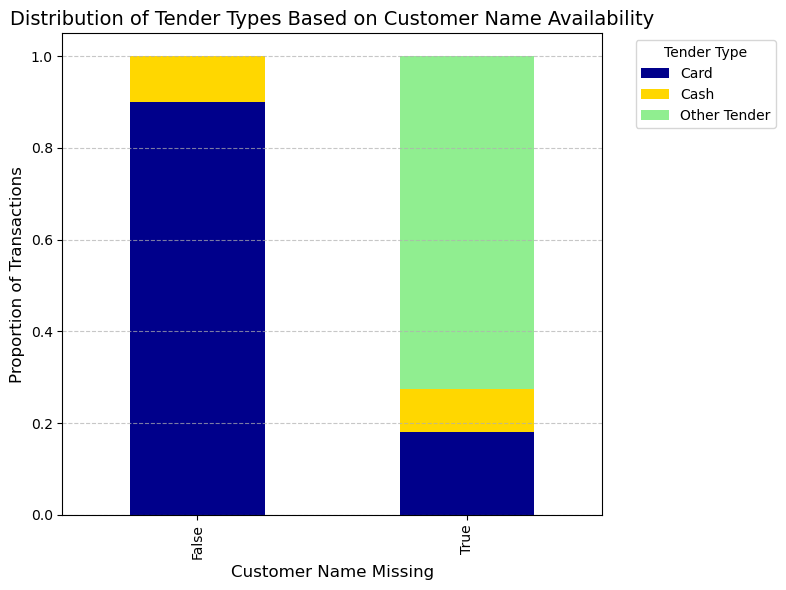

In [253]:
# Visualize tender types based on customer name missingness

# Add column for availabity of customer name
complete_trans.loc[:,'Customer Name Missing'] = complete_trans['Customer Name'].isnull()

# Sum amount grouped by name availability
name_grouped = complete_trans.groupby(by='Customer Name Missing')[['Card', 'Cash', 'Other Tender']].sum()

# Normalize values to have proportions
name_grouped = name_grouped.div(name_grouped.sum(axis=1), axis=0)

# Plot stacked bar chart
name_grouped.plot(kind='bar', stacked=True, color=['darkblue', 'gold', 'lightgreen'], figsize=(8,6))

plt.title('Distribution of Tender Types Based on Customer Name Availability', fontsize=14)
plt.xlabel('Customer Name Missing', fontsize=12)
plt.ylabel('Proportion of Transactions', fontsize=12)

plt.legend(title='Tender Type', bbox_to_anchor=(1.05, 1))

plt.grid(axis='y', alpha=0.7, linestyle='--')

plt.tight_layout()

plt.savefig(FIGURES_DIR / 'stacked_bar_tender_type_customer_name_availability.png', bbox_inches='tight')
plt.show()

#### Conclusions
- Customer names are primarily missing for transactions made with *Other Tender*. 
- Almost 90% of transactions with the customer name present were made with a card. 
- Both kinds had an equal amount of transactions made with cash. 
- This also explains the correlation in missingness between customer name and id with deposit information and fee information, since they are similarly correlated with tender type.

### Dining Option, Device Name and Order Reference ID
Missingness correlation is nearly -1 between Device Name and Order Reference ID, and Dining Option and Order Reference ID.

In [255]:
trans_df['Dining Option'].info()

<class 'pandas.core.series.Series'>
Index: 753 entries, 0 to 753
Series name: Dining Option
Non-Null Count  Dtype 
--------------  ----- 
219 non-null    object
dtypes: object(1)
memory usage: 11.8+ KB


In [267]:
# Counts of values

dining_value_counts = trans_df['Dining Option'].value_counts()
dining_value_counts

Dining Option
Pick Up              206
For Here               7
Delivery               3
Pick Up, For Here      2
Pick Up, Delivery      1
Name: count, dtype: int64

In [272]:
# Get percentage of each value

dining_value_counts / trans_df['Dining Option'].notnull().sum() * 100

Dining Option
Pick Up              94.063927
For Here              3.196347
Delivery              1.369863
Pick Up, For Here     0.913242
Pick Up, Delivery     0.456621
Name: count, dtype: float64

In [266]:
# Get % of missing values

trans_df['Dining Option'].isnull().sum() / len(trans_df) * 100

np.float64(70.91633466135458)

About 71% of values are missing in *Dining Option*. 94% of present values are labeled as *Pick Up*, 3% *For Here*, 1% *Delivery*, and then two outliers. *Pick Up, For Here* is about 1% and *Pick Up, Delivery* is 0.5%. We'll investigate these outliers and why they are labelled differently.

In [274]:
# Pick Up, For Here

pick_up_for_here = trans_df[trans_df['Dining Option'] == 'Pick Up, For Here']
pick_up_for_here

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
2,2023-11-30,2025-01-02 16:13:48,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,Point of Sale,0.00,NaN,0.0,0.0,NaN,0.00,0.00,wAoPFtaXlYgpRRew5r8c5v1eV,R0IvxtHDAvJRnoqZh3is8pkruaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,"2 x French fries (Rosemary, Full, Voided), “Ge...",Payment,"Pick Up, For Here",NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Voided,NaN
21,2024-01-06,2025-01-02 16:55:10,150.69,0.0,0.0,150.69,11.09,0.0,0.0,161.78,Point of Sale,161.78,Tapped,0.0,0.0,NaN,-4.31,157.47,MoXsNI8XlPrEoaSlJzqXWMveV,D7ZAXTRQF7v7NmILYNAjNLdtvaB,American Express,2007,Vartan,https://app.squareup.com/dashboard/sales/trans...,"5 x BELLY SLIDERS (4 sliders) - Tender, glazed...",Payment,"Pick Up, For Here",Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,0.0,3ZSKE8Z3R0MH4RX8766CH6KGQWNS,2024-01-06,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN


First transaction was voided. The completed transaction does not have any other outlier characteristics.

In [275]:
# Pick Up, Delivery

pick_up_delivery = trans_df[trans_df['Dining Option'] == 'Pick Up, Delivery']
pick_up_delivery

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
158,2024-05-02,2025-01-02 16:41:53,27.54,0.0,0.0,27.54,1.72,0.0,0.0,29.26,Point of Sale,0.0,NaN,29.26,0.0,NaN,0.0,29.26,yDL6YM5jVmT8Vd3yPlgBMjzeV,3LkKymeOmBefJCRHHzySMWxfvaB,NaN,NaN,Dashboard Belly Rubb,https://app.squareup.com/dashboard/sales/trans...,BAKED BABY POTATOES (Regular) - For those who ...,Payment,"Pick Up, Delivery",NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,NaN


This outlier also doesn't have any noticeable characteristics to differentiate from other orders. 

In [277]:
option_missing = trans_df[trans_df['Dining Option'].isna()]
option_missing.head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
3,2023-12-05,2025-01-02 16:12:32,44.16,0.0,0.0,44.16,4.20,0.00,0.0,48.36,Square Online,48.36,Keyed,0.0,0.0,NaN,-1.70,46.66,85Ohwx4gPrfiynZJjKgKeJ7k7POZY,FMr15YGavlmjOm2GSxZZJGYwZEWZY,MasterCard,9004.0,NaN,https://app.squareup.com/dashboard/sales/trans...,2 x MAC&CHEESE (8 oz.) - Here’s to taking the ...,Payment,NaN,TQR1MWV3DD53N64TY1FT5YEHP0,Alissa Khachmanyan,0.0,3ZVW7JKH4ZJ10EF4D9BDJ4AJ7TEH,2023-12-05,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,11ee93cbd6b99b0caf423cecef6dbaf0
4,2023-12-07,2025-01-02 12:44:33,28.98,0.0,0.0,28.98,2.75,5.80,0.0,37.53,Square Online,37.53,Keyed,0.0,0.0,NaN,-1.39,36.14,EDn6LPZxDq4Md7Th98OE0TQ4Q1GZY,1qsC2RdR9JBEiLBNxsXLJNKQVUNZY,Visa,5658.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Half rack) - Juicy, succu...",Payment,NaN,Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,0.0,3ZSM1F1BGKWS4Q37A590QHYGH655,2023-12-07,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,11ee9541284203e6af423cecef6dbaf0
5,2023-12-09,2025-01-02 14:29:54,-74.10,0.0,0.0,-74.10,-7.04,-14.82,0.0,-95.96,Point of Sale,-95.96,Keyed,0.0,0.0,NaN,0.00,-95.96,uVh61UleK3NqFaLKt9YpWG2eV,bLxBY8QZHfkvM78ktCGQp9E5g6WZY,MasterCard,299.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Full Rack) - Juicy, succu...",Refund,NaN,NaN,NaN,0.0,3Z7CHTKRCQWX0Y711HZ9C4C2F2A5,2023-12-09,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,NaN
6,2023-12-09,2025-01-02 13:19:42,74.10,0.0,0.0,74.10,7.04,14.82,0.0,95.96,Square Online,95.96,Keyed,0.0,0.0,NaN,-3.08,92.88,EdI6bYmV3RObEJPKCymrNv6EIQLZY,bLxBY8QZHfkvM78ktCGQp9E5g6WZY,MasterCard,299.0,NaN,https://app.squareup.com/dashboard/sales/trans...,THE BABY BACK COMBO (Crinkle Fries- Rosemary P...,Payment,NaN,0BGYJMQ4GZT0VTE3D98AE51TER,Arus Keshishyan,0.0,3ZVRCC2PGJN57D3BP3H1GXA5CW1H,2023-12-09,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,11ee96d8028fa2aaaf423cecef6dbaf0
7,2023-12-13,2025-01-02 17:08:37,86.84,0.0,0.0,86.84,8.25,13.03,0.0,108.12,Square Online,108.12,Keyed,0.0,0.0,NaN,-3.44,104.68,0pua7lQamI5CCtUq43TmHXo7jU8YY,LZgdp6gejId2tUMC8G3Te4tpsFSZY,Visa,6175.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"2 x GET YOUR BABY BACK! (Full Rack) - Juicy, s...",Payment,NaN,WG8AZ9EW89CN9JZKY5GPEWKT6W,Michael Keshishyan,0.0,3Z5DQPF6Y1C5409AS1X8CBYJESM9,2023-12-13,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,Complete,11ee9a1ce887aac3af423cecef6dbaf0


In [278]:
option_present = trans_df[trans_df['Dining Option'].notna()]
option_present.head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID
0,2023-11-27,2025-01-02 18:11:12,10.89,0.0,0.0,10.89,0.0,0.0,0.0,10.89,Point of Sale,10.89,Tapped,0.00,0.0,NaN,-0.38,10.51,sMznCMvA9sG5OwWqBdnWvg3eV,7pgJeys0KWsK5IGLFYCo8fafuaB,Visa,5728.0,NaN,https://app.squareup.com/dashboard/sales/trans...,"French fries (Rosemary, Side), Pineapple Coles...",Payment,For Here,4GBWG86RY6TE2YMWR0JN7S0XQC,Emily Samvalian,0.0,3ZQ9S0C1TFZ91SK87PZJCAJYSX1N,2023-11-29,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN
1,2023-11-27,2025-01-02 13:37:08,88.56,0.0,0.0,88.56,0.0,0.0,0.0,88.56,Point of Sale,0.00,NaN,88.56,0.0,NaN,0.00,88.56,GRjFkwdOFJlIXYiHIP6XwNoeV,fTEPnGM8IqeBWDl65MPdzEtRvaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,2 x “Get your baby back” Pork Ribs (Full Rack)...,Payment,Pick Up,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,NaN
2,2023-11-30,2025-01-02 16:13:48,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,Point of Sale,0.00,NaN,0.00,0.0,NaN,0.00,0.00,wAoPFtaXlYgpRRew5r8c5v1eV,R0IvxtHDAvJRnoqZh3is8pkruaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,"2 x French fries (Rosemary, Full, Voided), “Ge...",Payment,"Pick Up, For Here",NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Voided,NaN
8,2023-12-17,2025-01-02 20:09:48,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,Point of Sale,0.00,NaN,0.00,0.0,NaN,0.00,0.00,mVJvqQWCLO6IAUJtzArpk5weV,tuyX6STdqalIky1G0VxqcNmKvaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,"PINEAPPLE SLAW (Full, Voided) - Fruity meets s...",Payment,For Here,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Voided,NaN
9,2023-12-17,2025-01-02 20:08:22,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,Point of Sale,0.00,NaN,0.00,0.0,NaN,0.00,0.00,y3NqcrlWcstH9OUJkHXWqggeV,HFZ2xgqjpjl5D2Vbx7sMAbO4uaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,"BELLY SLIDERS (4 sliders, Voided) - Tender, gl...",Payment,For Here,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Voided,NaN


In [279]:
option_present.describe()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Card,Cash,Other Tender,Fees,Net Total,Third Party Fees,Fee Percentage Rate,Fee Fixed Rate
count,219,219,219.000000,219.000000,219.0,219.000000,219.000000,219.000000,219.0,219.000000,219.000000,219.000000,219.0,219.000000,219.000000,219.0,124.000000,124.000000
mean,2024-07-26 22:34:31.232876800,2025-01-02 15:53:53.557077248,46.814338,-0.043562,0.0,46.770776,4.172009,0.233105,0.0,51.175890,32.273014,18.902877,0.0,-0.985662,50.190228,0.0,2.765323,0.110484
min,2023-11-27 00:00:00,2025-01-02 00:05:39,-358.350000,-5.000000,0.0,-358.350000,-34.040000,0.000000,0.0,-392.390000,-49.040000,-392.390000,0.0,-10.050000,-392.390000,0.0,2.600000,0.100000
25%,2024-05-14 00:00:00,2025-01-02 13:12:03.500000,20.350000,0.000000,0.0,20.350000,1.900000,0.000000,0.0,22.280000,0.000000,0.000000,0.0,-1.485000,21.885000,0.0,2.600000,0.100000
50%,2024-08-16 00:00:00,2025-01-02 16:13:48,37.480000,0.000000,0.0,37.480000,3.520000,0.000000,0.0,41.040000,18.940000,0.000000,0.0,-0.590000,40.790000,0.0,2.600000,0.100000
75%,2024-10-22 12:00:00,2025-01-02 18:47:01,62.725000,0.000000,0.0,62.725000,5.685000,0.000000,0.0,68.625000,51.645000,26.635000,0.0,0.000000,67.490000,0.0,2.600000,0.100000
max,2024-12-19 00:00:00,2025-01-02 22:58:24,358.350000,0.000000,0.0,358.350000,34.040000,25.000000,0.0,392.390000,341.160000,392.390000,0.0,0.000000,392.390000,0.0,3.500000,0.300000
std,NaN,NaN,57.453601,0.455325,0.0,57.442696,5.173385,1.856174,0.0,62.608946,47.092673,54.109728,0.0,1.441058,61.855368,0.0,0.348293,0.025721


In [280]:
option_missing.describe()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Card,Cash,Other Tender,Fees,Net Total,Third Party Fees,Fee Percentage Rate,Fee Fixed Rate
count,534,534,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.0,534.000000,534.000000,534.000000,534.000000,160.000000,160.000000
mean,2024-08-06 22:41:47.865168384,2025-01-02 16:05:51.853932544,53.723221,-0.069045,0.384251,53.654176,4.868315,1.144157,-0.190075,59.476573,23.494888,0.0,35.612659,-1.376161,58.100412,0.596610,2.921250,0.297812
min,2023-12-05 00:00:00,2025-01-02 01:46:37,-81.470000,-5.980000,0.000000,-81.470000,-7.260000,-14.820000,-85.060000,-95.960000,-95.960000,0.0,-88.730000,-59.000000,-95.960000,0.000000,2.600000,0.100000
25%,2024-06-07 00:00:00,2025-01-02 13:42:14.500000,26.320000,0.000000,0.000000,26.305000,2.375000,0.000000,0.000000,29.495000,0.000000,0.0,0.000000,-1.030000,28.877500,0.000000,2.900000,0.300000
50%,2024-08-31 00:00:00,2025-01-02 16:43:02,41.920000,0.000000,0.000000,41.920000,3.575000,0.000000,0.000000,45.810000,0.000000,0.0,31.450000,0.000000,44.305000,0.000000,2.900000,0.300000
75%,2024-10-30 00:00:00,2025-01-02 18:28:30.249999872,59.750000,0.000000,0.000000,59.407500,5.457500,0.000000,0.000000,66.450000,24.560000,0.0,53.572500,0.000000,64.587500,0.000000,2.900000,0.300000
max,2024-12-20 00:00:00,2025-01-02 22:17:49,1039.950000,1.700000,35.800000,1039.950000,98.800000,21.130000,0.000000,1158.750000,1158.750000,0.0,487.110000,15.490000,1124.850000,46.290000,6.000000,0.300000
std,NaN,NaN,66.617740,0.537340,2.526075,66.630023,6.277931,3.279482,3.740342,74.662911,74.475631,0.0,40.932716,4.804189,72.198243,3.599282,0.250631,0.019704


There are no cash transactions in those with the dining option missing.

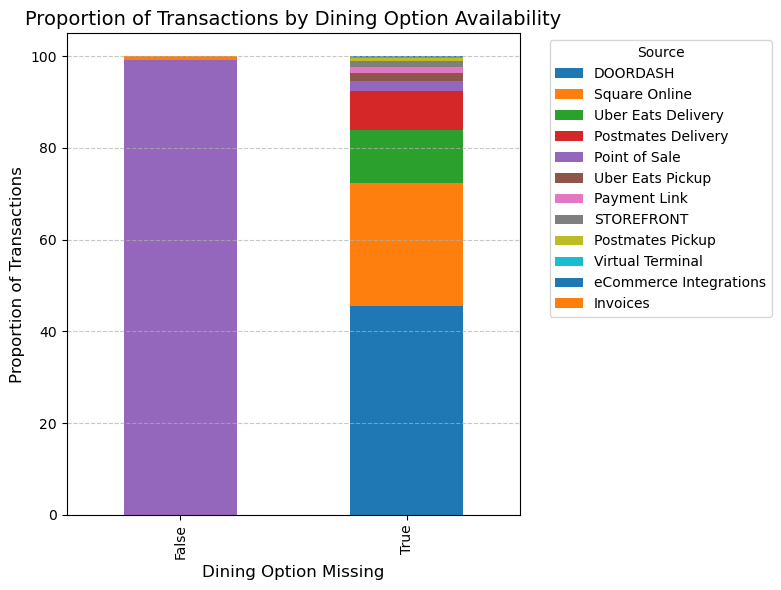

In [ ]:
# Visualize missinging dining option by source

# Create new col to store whether dining option is missing
trans_df['Dining Option Missing'] = trans_df['Dining Option'].isna()

# Generate ratio missing
dining_option_grouped = trans_df.groupby(by='Dining Option Missing')['Source'].value_counts().unstack(fill_value=0)
dining_option_percent = dining_option_grouped.div(dining_option_grouped.sum(axis=1), axis=0) * 100

# Sort columns for visual ease in stacked bar chart
sorted_cols = dining_option_percent.loc[True].sort_values(ascending=False).index
dining_option_percent = dining_option_percent[sorted_cols]

# Plot
dining_option_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(8,6)
)

plt.legend(title='Source', bbox_to_anchor=(1.05, 1))
plt.xlabel('Dining Option Missing', fontsize=12)
plt.ylabel('Proportion of Transactions', fontsize=12)
plt.title('Proportion of Transactions by Dining Option Availability', fontsize=14)

plt.grid(axis='y', alpha=0.7, linestyle='--')

plt.tight_layout()

plt.savefig(FIGURES_DIR / 'stacked_bar_dining_option_source.png', bbox_inches='tight')
plt.show()


It's pretty clear from this graph that nearly all orders made with the POS contain a dining option. On the other hand, all other transactions from other sources are missing the dining option.

In [321]:
dining_option_device = trans_df.groupby(by='Dining Option Missing')['Device Name'].value_counts()
dining_option_device

Dining Option Missing  Device Name         
False                  Vartan                  135
                       Dashboard Belly Rubb     81
                       Vartan’s iPad             1
True                   Vartan                    1
Name: count, dtype: int64

In [324]:
vartan_device = complete_trans[complete_trans['Device Name'] == 'Vartan']
vartan_device.head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID,Customer Name Missing
1,2023-11-27,2025-01-02 13:37:08,88.56,0.0,0.0,88.56,0.00,0.0,0.0,88.56,Point of Sale,0.00,NaN,88.56,0.0,NaN,0.00,88.56,GRjFkwdOFJlIXYiHIP6XwNoeV,fTEPnGM8IqeBWDl65MPdzEtRvaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,2 x “Get your baby back” Pork Ribs (Full Rack)...,Payment,Pick Up,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Complete,NaN,True
14,2023-12-31,2025-01-02 17:42:54,115.07,0.0,0.0,115.07,10.93,0.0,0.0,126.00,Point of Sale,126.00,Tapped,0.00,0.0,NaN,-3.38,122.62,UiMrcBvXQpdYgw9Uv6rANFqeV,T5eHErUi2fuJiAQXLlQnAsXEuaB,American Express,2007.0,Vartan,https://app.squareup.com/dashboard/sales/trans...,"BELLY SLIDERS (6 sliders) - Tender, glazed por...",Payment,For Here,Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,0.0,3Z561QY9TAVX7ZF8E5VPVY0TA0RX,2023-12-31,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN,False
20,2024-01-05,2025-01-02 15:35:32,51.44,0.0,0.0,51.44,4.89,0.0,0.0,56.33,Point of Sale,56.33,Tapped,0.00,0.0,NaN,-1.56,54.77,4EMJZdahqZfatjRKjlwQBveeV,bNEInqDuctA3ZTwhtPcQpaFFuaB,Visa,7360,Vartan,https://app.squareup.com/dashboard/sales/trans...,"3 x BELLY SLIDERS (2 sliders) - Tender, glazed...",Payment,For Here,NaN,NaN,0.0,3Z4ST23PFWYS0GKCFY77HPP9RDXD,2024-01-05,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN,True
21,2024-01-06,2025-01-02 16:55:10,150.69,0.0,0.0,150.69,11.09,0.0,0.0,161.78,Point of Sale,161.78,Tapped,0.00,0.0,NaN,-4.31,157.47,MoXsNI8XlPrEoaSlJzqXWMveV,D7ZAXTRQF7v7NmILYNAjNLdtvaB,American Express,2007,Vartan,https://app.squareup.com/dashboard/sales/trans...,"5 x BELLY SLIDERS (4 sliders) - Tender, glazed...",Payment,"Pick Up, For Here",Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,0.0,3ZSKE8Z3R0MH4RX8766CH6KGQWNS,2024-01-06,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN,False
22,2024-01-06,2025-01-02 16:55:31,26.98,0.0,0.0,26.98,2.56,0.0,0.0,29.54,Point of Sale,29.54,Tapped,0.00,0.0,NaN,-0.87,28.67,mfYUKul1XGJLREel7lqabMveV,HdLB7BtsEoiXMSeoOhB8kZAJuaB,American Express,2007,Vartan,https://app.squareup.com/dashboard/sales/trans...,"GET YOUR BABY BACK! (Half rack) - Juicy, succu...",Payment,Pick Up,Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,0.0,3Z6KXRD5REVH3ZQCR0MM2HMA1AWS,2024-01-06,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN,False


In [326]:
vartan_device['Card Entry Methods'].unique()

array([nan, 'Tapped', 'Dipped'], dtype=object)

In [327]:
trans_df[(trans_df['Device Name'] == 'Vartan') & (trans_df['Dining Option Missing'] == True)]

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID,Dining Option Missing
139,2024-04-17,2025-01-02 15:43:45,0.0,0.0,0.0,0.0,0.0,0.0,-0.95,-0.95,Point of Sale,-0.95,Tapped,0.0,0.0,NaN,0.0,-0.95,eFVWLFiT5lfYUV374eobHYjeV,BMuww3jmSKU5GHrq9PPvLqqiuaB,Visa,5616,Vartan,https://app.squareup.com/dashboard/sales/trans...,Custom Amount,Refund,NaN,NaN,NaN,0.0,3ZCEW60QT54978FDQVC9TSS9YS9N,2024-04-17,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Complete,NaN,True


In [329]:
trans_df[trans_df['Device Name'] == "Vartan’s iPad"]

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Transaction Status,Order Reference ID,Dining Option Missing
316,2024-08-03,2025-01-02 16:17:45,23.98,0.0,0.0,23.98,2.28,0.0,0.0,26.26,Point of Sale,26.26,Keyed,0.0,0.0,NaN,-1.07,25.19,UDf6SadTaf2A3dNODASFxljmR0VZY,BoKNDrtty6YoGem2vkvwDTwHsP8YY,Visa,9992,Vartan’s iPad,https://app.squareup.com/dashboard/sales/trans...,"BABY BACK RIB COMBO (Regular) - Flying solo, o...",Payment,Pick Up,PRJ1E735VK59SJ4J0AVM21YJ4G,NaN,0.0,3ZTK52NA4DQX5WZDCFBGC89GY7NH,2024-08-03,https://app.squareup.com/dashboard/sales/depos...,3.5,0.15,Complete,NaN,False


#### Conclusions
- Nearly all orders made with the POS contain a dining option. All other transactions from other sources are missing the dining option.
- Device information is present for orders made with the POS system or by the owner himself. It is missing for other orders.

## Correlations
- Card Brand with Discount Name, Fee Fixed Rate, and Transaction Status
- Card Entry Methods with Device Name, Discount Name, and Fee Fixed Rate
- Device Name with Service Charges and Source
- Dining Option with Discount Name, Partial Refunds, Refund Reason, Service Charges
- Discount Name with Card Brand, Card Entry Methods, Device Name, Dining Option, Discounts, Fee Fixed Rate, Partial Refunds, Source, Transaction Status
- Discounts with Discount Name
- Event Type with Refund Reason
- Fee Fixed Rate with Card Brand, Card Entry Methods, Device Name, Discount Name, Source, Transaction Status
- Partial Refunds with Dining Option, Discount Name, Refund Reason, Source
- Refund Reason with Device Name, Dining Option, Event Type, PArtial Refunds, Service Charges, Source, Third Party Fees, Transaction Status
- Service Charges with Device Name, Dining Option, Refund Reason, Third Party Fees
- Source with Device Name, Discount Name, Fee Fixed Rate, Partial Refunds, Refund Reason
- Third Party Fees with Device Name, Dining Option, Refund Reason, Service Charges
- Transaction Status with Card Brand, Card Entry Methods, Discount Name, Fee Fixed Rate, Refund Reason

### Card Brand with Discount Name, Fee Fixed Rate, and Transaction Status

We already know that card brand and fee fixed rate are correlated because only credit card transactions have an applied fee. The fee is not dependent on the card brand but rather on the kind of transaction and its corresponding fraud risk. We'll instead focus on the correlation between card brand and both discount name and transaction status.

In [363]:
# Number of transactions with each coupon

discount_name_counts = trans_df['Discount Name'].value_counts().reset_index()
discount_name_counts

,Discount Name,count
0,"Discount: Coupon GETYOURBABYBACK!, Discount: C...",5
1,10% off all orders—GETYOURBABYBACK!,4
2,"Discount: Coupon GETYOURBABYBACK!, Discount: C...",2
3,"Discount: Coupon GETYOURBABYBACK!, Discount: C...",2
4,Coupon,1
5,Family and Friends,1


In [388]:
# Transactions with at least 1 'getyourbabyback' coupon applied

coupon_regex = r'(?i)getyourbabyback'
coupon_transactions = trans_df[trans_df['Discount Name'].str.contains(coupon_regex, na=False)]
coupon_transactions.head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Discount Name,Transaction Status,Order Reference ID
67,2024-02-28,2025-01-04 15:16:26,59.96,-4.80,11.99,55.16,4.10,0.00,0.0,59.26,Square Online,59.26,Keyed,0.0,0.0,NaN,-15.51,43.75,aIuL3GgSLuE0eI7rgEMi0iv4EZVZY,J4QxDk2NEbUiH9ZlEH2f57BmNSNZY,Visa,1312,NaN,https://app.squareup.com/dashboard/sales/trans...,"THE BABY BACK COMBO (Regular) - Flying solo, o...",Payment,NaN,RD0RAP0N9N5J51GMN8Y7TGGKWC,Gabriela Estrada,13.49,3ZGXGCKM3FKS7T30M7QT4GW6H2V5,2024-02-28,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,"Discount: Coupon GETYOURBABYBACK!, Discount: C...",Complete,11eed68ea6de4736b9b13cecef6dbae8
111,2024-03-29,2025-01-04 14:19:02,22.54,-2.25,0.00,20.29,1.93,4.51,0.0,26.73,Square Online,26.73,Keyed,0.0,0.0,NaN,-1.08,25.65,qyLzKFtWZu1F8CNRLJFNu2tKXe6YY,ZKzWqQxTF7dYOtEudCGkUCeg1vDZY,Visa,9304,NaN,https://app.squareup.com/dashboard/sales/trans...,STEAK SANDWICH COMBO (Regular) - This combo is...,Payment,NaN,JCJ1X244D95FZ8JYTX0VZEKCH8,Alexander Diaz,0.00,3ZAVGT1BXQG96KFA0TJT3VTKMT2S,2024-03-29,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,"Discount: Coupon GETYOURBABYBACK!, Discount: C...",Complete,11eeee11a9d7a5e2b9b13cecef6dbae8
122,2024-04-04,2025-01-04 13:57:34,21.78,-2.18,0.00,19.60,1.86,5.00,0.0,26.46,Square Online,26.46,Keyed,0.0,0.0,NaN,-1.07,25.39,MTrNHqEWyvqpPebtJ2gTQTTos6dZY,NCqGso1EkVDeey8XNz4O7AzfrDXZY,Visa,9304,NaN,https://app.squareup.com/dashboard/sales/trans...,CHICKEN WINGS (8 pcs) - Jucy and Crispy. Fully...,Payment,NaN,JCJ1X244D95FZ8JYTX0VZEKCH8,Alexander Diaz,0.00,3ZCSDSS5PFV55QH25ZVMSW4HCN3H,2024-04-04,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,"Discount: Coupon GETYOURBABYBACK!, Discount: C...",Complete,11eef2c59752749cb9b13cecef6dbae8
140,2024-04-17,2025-01-04 14:37:29,17.28,-1.73,0.00,15.55,1.48,4.00,0.0,21.03,Square Online,21.03,Keyed,0.0,0.0,NaN,-0.91,20.12,Ez72IY08NBHk0xbLL6KOuu0oOx8YY,nR5NmhedS6F58rCSHNBXLSyVszYZY,Visa,9304,NaN,https://app.squareup.com/dashboard/sales/trans...,CHICKEN WINGS (6 pcs) - Jucy and Crispy. Fully...,Payment,NaN,JCJ1X244D95FZ8JYTX0VZEKCH8,Alexander Diaz,0.00,3ZGZTKZXKCCH3CHB601859AK5Q51,2024-04-17,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,"Discount: Coupon GETYOURBABYBACK!, Discount: C...",Complete,11eefd024c666d25b9b13cecef6dbae8
156,2024-04-25,2025-01-04 14:04:06,13.24,-1.32,0.00,11.92,1.13,4.00,0.0,17.05,Square Online,17.05,Keyed,0.0,0.0,NaN,-0.79,16.26,y6dNRKifp0HVL2SEbn4UTAlraHOZY,V6q5Cf51832pshOR5HEdF5112JeZY,Visa,9304,NaN,https://app.squareup.com/dashboard/sales/trans...,CHICKEN WINGS (6 pcs) - Jucy and Crispy. Fully...,Payment,NaN,JCJ1X244D95FZ8JYTX0VZEKCH8,Alexander Diaz,0.00,3Z6077M7MM0S271EPSHG3K2XNJH1,2024-04-25,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,"Discount: Coupon GETYOURBABYBACK!, Discount: C...",Complete,11ef03470a0f19dcb9b13cecef6dbae8


In [405]:
# Define method to confirm discount calculation

def check_discount(row):
    """Confirm discount calculation
    
    Params:
        row (pd.Series): Individual transaction
        
    Returns:
        bool: True if discount calculated correctly, false otherwise
    """
    return (row['Discounts'] == -round(row['Gross Sales'] * 0.1, 2))

In [418]:
# Apply discount confirmation

verified_coupons = coupon_transactions.apply(check_discount, axis=1)
verified_coupons

67     False
111     True
122     True
140     True
156     True
160     True
197     True
212     True
277     True
443     True
444     True
445     True
575     True
dtype: bool

It looks like generally, even if a coupon is listed multiple times under Discount Name, it is only applied once. Only one transaction did not have the coupon applied as 10%.

In [421]:
# Extract outlier

coupon_outlier = coupon_transactions[~verified_coupons]
coupon_outlier

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Discount Name,Transaction Status,Order Reference ID
67,2024-02-28,2025-01-04 15:16:26,59.96,-4.8,11.99,55.16,4.1,0.0,0.0,59.26,Square Online,59.26,Keyed,0.0,0.0,NaN,-15.51,43.75,aIuL3GgSLuE0eI7rgEMi0iv4EZVZY,J4QxDk2NEbUiH9ZlEH2f57BmNSNZY,Visa,1312,NaN,https://app.squareup.com/dashboard/sales/trans...,"THE BABY BACK COMBO (Regular) - Flying solo, o...",Payment,NaN,RD0RAP0N9N5J51GMN8Y7TGGKWC,Gabriela Estrada,13.49,3ZGXGCKM3FKS7T30M7QT4GW6H2V5,2024-02-28,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,"Discount: Coupon GETYOURBABYBACK!, Discount: C...",Complete,11eed68ea6de4736b9b13cecef6dbae8


In [422]:
# Calculate discount applied to this order

round(-(coupon_outlier['Discounts'] / coupon_outlier['Gross Sales']) * 100, 2)

67    8.01
dtype: float64

This order only received an 8% discount.

In [425]:
# Check coupons applied

coupon_outlier['Discount Name'].values

array(['Discount: Coupon GETYOURBABYBACK!, Discount: Coupon GETYOURBABYBACK!, Discount: Coupon GETYOURBABYBACK!'],
      dtype=object)

There is no way to understand the discrepancy in applied discount to this order. It will be treated as an outlier.

In [427]:
# View order with discount name Coupon

coupon = trans_df[trans_df['Discount Name'] == 'Coupon']
coupon

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Discount Name,Transaction Status,Order Reference ID
170,2024-05-10,2025-01-04 19:46:34,77.76,-5.0,0.0,72.76,6.07,0.0,0.0,78.83,Point of Sale,78.83,Tapped,0.0,0.0,NaN,-2.15,76.68,635VsIeSMkf2xDgCJfVnQ8neV,TpMgFIkPQJrDSYmgj4SBsx5YuaB,American Express,3009,Vartan,https://app.squareup.com/dashboard/sales/trans...,GLAZED BABY BACK PORK RIBS (Full Rack) - Behol...,Payment,Pick Up,XP76D2T8HPJC3Z1J1KMSY3MR0C,NaN,0.0,3ZTSH9ZT3RMH2E13GMZ9S7F2NGH5,2024-05-10,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Coupon,Complete,NaN


In [429]:
# Calculate discount applied

-round(coupon['Discounts'] / coupon['Gross Sales'], 2) * 100

170    6.0
dtype: float64

It looks like the discount *Coupon* equates to 6% off.

In [430]:
family_friends = trans_df[trans_df['Discount Name'] == 'Family and Friends']
family_friends

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Discount Name,Transaction Status,Order Reference ID
718,2024-12-06,2025-01-04 20:19:45,47.79,-4.54,0.0,43.25,4.11,0.0,0.0,47.36,Point of Sale,47.36,Tapped,0.0,0.0,NaN,-1.33,46.03,YA4khXo2aqO8qsVWPmLYuT2eV,rv1unpZ7ekA0XG4nkI29h5xNuaB,Visa,5021,Vartan,https://app.squareup.com/dashboard/sales/trans...,"CHICKEN WINGS (12 pcs) - Juicy and Crispy, tot...",Payment,Pick Up,QBV2ABQ60HSDEKQBMS9WFWM6M0,NaN,0.0,3ZKDRJAQ74GH3E77ZJ5FTS1S2MKH,2024-12-06,https://app.squareup.com/dashboard/sales/depos...,2.6,0.1,Family and Friends,Complete,NaN


In [432]:
# Calculate family and friends discouns

-round(family_friends['Discounts'] / family_friends['Gross Sales'], 2) * 100

718    9.0
dtype: float64

Coupon *Family and Friends* applies 9% off the order.

In [437]:
# Count card brands used in coupon transactions

coupon_transactions['Card Brand'].value_counts()

Card Brand
Visa    13
Name: count, dtype: int64

It loos like all coupon transactions were made with visa cards, resulting in the correlation.

In [441]:
# Value counts of transaction status

trans_status = trans_df['Transaction Status'].value_counts(normalize=True) * 100
trans_status

Transaction Status
Complete    97.082228
Voided       2.917772
Name: proportion, dtype: float64

In [443]:
# Extract voided transactions

voided_trans = trans_df[trans_df['Transaction Status'] == 'Voided']
voided_trans.head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Discount Name,Transaction Status,Order Reference ID
2,2023-11-30,2025-01-04 16:13:48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Point of Sale,0.0,NaN,0.0,0.0,NaN,0.0,0.0,wAoPFtaXlYgpRRew5r8c5v1eV,R0IvxtHDAvJRnoqZh3is8pkruaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,"2 x French fries (Rosemary, Full, Voided), “Ge...",Payment,"Pick Up, For Here",NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,Voided,NaN
8,2023-12-17,2025-01-04 20:09:48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Point of Sale,0.0,NaN,0.0,0.0,NaN,0.0,0.0,mVJvqQWCLO6IAUJtzArpk5weV,tuyX6STdqalIky1G0VxqcNmKvaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,"PINEAPPLE SLAW (Full, Voided) - Fruity meets s...",Payment,For Here,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,Voided,NaN
9,2023-12-17,2025-01-04 20:08:22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Point of Sale,0.0,NaN,0.0,0.0,NaN,0.0,0.0,y3NqcrlWcstH9OUJkHXWqggeV,HFZ2xgqjpjl5D2Vbx7sMAbO4uaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,"BELLY SLIDERS (4 sliders, Voided) - Tender, gl...",Payment,For Here,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,Voided,NaN
13,2023-12-31,2025-01-04 17:48:40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Point of Sale,0.0,NaN,0.0,0.0,NaN,0.0,0.0,oKZqeWVoZAj6zQSRihb6vvueV,rpOi2ZGmSFxhO8R5qm9NlUi0vaB,NaN,NaN,Dashboard Belly Rubb,https://app.squareup.com/dashboard/sales/trans...,"BELLY SLIDERS (6 sliders, Voided) - Tender, gl...",Payment,For Here,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,Voided,NaN
19,2024-01-05,2025-01-04 15:34:06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Point of Sale,0.0,NaN,0.0,0.0,NaN,0.0,0.0,61QDrhPRmvUAFb4JonCzP9leV,R4M4NFfGLGQGtgbfOzAsGrAxvaB,NaN,NaN,Vartan,https://app.squareup.com/dashboard/sales/trans...,"2 x MAC&CHEESE (Side, Voided) - Here’s to taki...",Payment,For Here,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,Voided,NaN


In [444]:
# Card brands of voided transactions

voided_trans['Card Brand'].value_counts()

Series([], Name: count, dtype: int64)

In [446]:
complete_trans['Card Brand'].value_counts(normalize=True) * 100

Card Brand
Visa                70.671378
MasterCard          15.547703
American Express    11.660777
Discover             2.120141
Name: proportion, dtype: float64

70% of transactions were made with a Visa. 

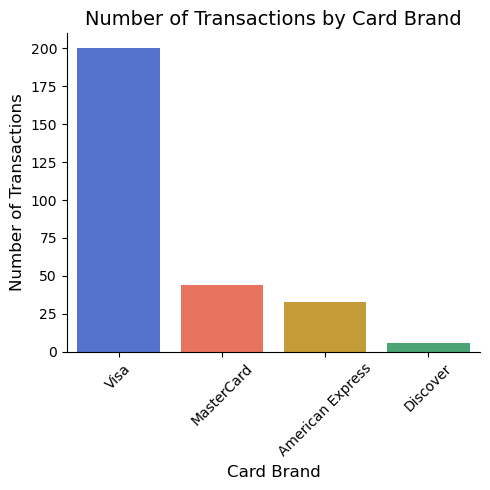

In [476]:
# Visualize card brand count

sns.catplot(
    data=trans_df,
    x='Card Brand',
    hue='Card Brand',
    kind='count',
    palette=['#4169E1', '#FF6347', '#DAA520', '#3CB371'],
    legend=False
)

plt.xlabel('Card Brand', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=45)
plt.title('Number of Transactions by Card Brand', fontsize=14)

plt.tight_layout()

plt.savefig(FIGURES_DIR / 'bar_card_brand_transactions.png', bbox_inches='tight')
plt.show()

#### Conclusions:
- Even if listed multiple times, a coupon is only applied once.
- *getyourbabyback* coupon applies a 10% discount, *coupon* applies a 6% discount, and *family and friends* applies a 9% discount.
- All discounted transactions were made with a Visa card brand.
- 70% of transactions were made with a Visa, resulting in a high correlation between transaction status and card brand.

### Card Entry Methods with Device Name, Discount Name, and Fee Fixed Rate

We already know that the method with which card information is inputted affects the fees. This is because certain methods, such as keying in information, have a higher risk of fraud and therefore face larger fees from Square.

In [477]:
# Possible card entry methods

trans_df['Card Entry Methods'].unique()

array(['Tapped', nan, 'Keyed', 'On File', 'Dipped'], dtype=object)

In [484]:
# # of transactions on each device used grouped by card entry method

trans_df.groupby(by='Card Entry Methods')['Device Name'].value_counts(dropna=False, normalize=True) * 100

Card Entry Methods  Device Name         
Dipped              Vartan                  100.000000
Keyed               NaN                      87.209302
                    Dashboard Belly Rubb     12.209302
                    Vartan’s iPad             0.581395
On File             NaN                     100.000000
Tapped              Vartan                   98.979592
                    NaN                       1.020408
Name: proportion, dtype: float64

Physical cards are typically used with the device *Vartan*, most likely the name of the POS. *Keyed* transactions are made from the Square dashboard or Vartan's iPad. 

In [488]:
# Percent of discounted transactions by card entry method

coupon_transactions['Card Entry Methods'].value_counts(normalize=True) * 100

Card Entry Methods
Keyed    100.0
Name: proportion, dtype: float64

100% of discounted transactions were made by keying in the card information.

In [507]:
coupon_transactions['Cash'].sum()

np.float64(0.0)

#### Conclusions:
- Physical cards are used with the device *Vartan*
- Keyed transactions are made from the Square dashboard minus one from *Vartan's iPad*
- Discounts are only accessible to keyed transactions.

### Device Name with Service Charges and Source

In [490]:
# Service charges summary statistics

trans_df['Service Charges'].describe()

count    754.000000
mean       0.272135
std        2.132437
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       35.800000
Name: Service Charges, dtype: float64

In [501]:
# Unique service charge values

trans_df['Service Charges'].value_counts().sort_index()

Service Charges
0.00     738
3.00       1
5.00       1
5.74       1
8.02       1
10.00      1
10.09      1
10.83      1
11.99      1
12.51      1
13.54      1
13.99      2
14.75      1
15.79      1
20.15      1
35.80      1
Name: count, dtype: int64

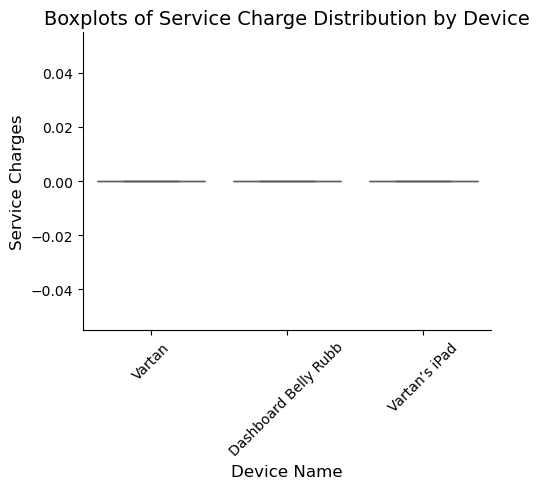

In [503]:
# Visualize service charge distribution by device

sns.catplot(
    data=trans_df,
    kind='box',
    x='Device Name',
    y='Service Charges'
)

plt.xlabel('Device Name', fontsize=12)
plt.ylabel('Service Charges', fontsize=12)
plt.title('Boxplots of Service Charge Distribution by Device', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

It looks like transactions with a device name have service charges of 0. This implies that service charges are applied to orders missing the device name, which was orders placed from other sources.

In [506]:
service_charge_trans = trans_df[trans_df['Service Charges'] > 0]
service_charge_trans.head()

,Date,Time,Gross Sales,Discounts,Service Charges,Net Sales,Tax,Tip,Partial Refunds,Total Collected,Source,Card,Card Entry Methods,Cash,Other Tender,Tender Note,Fees,Net Total,Transaction ID,Payment ID,Card Brand,PAN Suffix,Device Name,Details,Description,Event Type,Dining Option,Customer ID,Customer Name,Third Party Fees,Deposit ID,Deposit Date,Deposit Details,Fee Percentage Rate,Fee Fixed Rate,Discount Name,Transaction Status,Order Reference ID,Dining Option Missing
31,2024-01-17,2025-01-04 11:47:27,154.50,0.0,20.15,154.50,12.76,0.0,0.0,167.26,Square Online,167.26,Keyed,0.0,0.0,NaN,-33.79,133.47,gdTTGdcrXwOrnGMT3a4vgQAIaG8YY,X7YMwX8DKhnmCYpOpQ9LFuC6B6CZY,MasterCard,2608,NaN,https://app.squareup.com/dashboard/sales/trans...,2 x GRILLED SWEET CORN (Regular) - Grilled swe...,Payment,NaN,5KAFXG8VMJANNPY43YMKKXPFQW,Khoren Mamikonian,28.64,3ZC8TT7BW7F51KV76EMMACA72581,2024-01-17,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,NaN,Complete,11eeb5706689e92faf423cecef6dbaf0,True
67,2024-02-28,2025-01-04 15:16:26,59.96,-4.8,11.99,55.16,4.10,0.0,0.0,59.26,Square Online,59.26,Keyed,0.0,0.0,NaN,-15.51,43.75,aIuL3GgSLuE0eI7rgEMi0iv4EZVZY,J4QxDk2NEbUiH9ZlEH2f57BmNSNZY,Visa,1312,NaN,https://app.squareup.com/dashboard/sales/trans...,"THE BABY BACK COMBO (Regular) - Flying solo, o...",Payment,NaN,RD0RAP0N9N5J51GMN8Y7TGGKWC,Gabriela Estrada,13.49,3ZGXGCKM3FKS7T30M7QT4GW6H2V5,2024-02-28,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,"Discount: Coupon GETYOURBABYBACK!, Discount: C...",Complete,11eed68ea6de4736b9b13cecef6dbae8,True
136,2024-04-13,2025-01-04 16:00:13,63.14,0.0,5.74,63.14,5.45,0.0,0.0,68.59,Square Online,68.59,On File,0.0,0.0,NaN,-18.52,50.07,uWK2WKO7UMw0LBXWyfVGV7AxmrQZY,7ZqGyl3ALNk3TA9bJ7cEW9eXbB8YY,Visa,7690,NaN,https://app.squareup.com/dashboard/sales/trans...,"Beef Short Rib (Regular) - Incredibly tender, ...",Payment,NaN,ET55RV7R293EZABFWD0N72YEE0,Bryce Middleton,16.23,3ZEWHJ5TVXCS6CK5AJRV4EW5Z0VS,2024-04-13,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,NaN,Complete,11eef9e7ed45eb9bb9b13cecef6dbae8,True
169,2024-05-10,2025-01-04 18:43:52,35.96,0.0,12.51,35.96,2.23,0.0,0.0,38.19,Square Online,38.19,Keyed,0.0,0.0,NaN,-15.42,22.77,YBLpJQZ65X3uPNnj4kQYckOK0lfZY,LfJwlsiDddvEoY7xZfZ0wHANszCZY,Visa,6175,NaN,https://app.squareup.com/dashboard/sales/trans...,STEAK SANDWICH COMBO (Regular) - This combo is...,Payment,NaN,WG8AZ9EW89CN9JZKY5GPEWKT6W,Michael Keshishyan,14.01,3ZWH2G0V2GWH2RZ9CZMYZ6TY5PXX,2024-05-10,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,NaN,Complete,11ef0f378e0fa166b9b13cecef6dbae8,True
194,2024-05-31,2025-01-04 15:24:51,29.23,0.0,10.83,29.23,1.75,0.0,0.0,30.98,Square Online,30.98,Keyed,0.0,0.0,NaN,-13.53,17.45,2yK0EWBvvUnLLsmqmfMlqu6BppDZY,3hV3ttSP32EIby7i2QjDRZdx2vLZY,Visa,2693,NaN,https://app.squareup.com/dashboard/sales/trans...,THE BELLY COMBO (Regular) - Enjoy the ultimate...,Payment,NaN,BRET0KG4Q127HFWN9MP5HQR820,Alejandra Mejia,12.33,3Z87MTDFGWRS7PK0K0YJH4JHWD3X,2024-05-31,https://app.squareup.com/dashboard/sales/depos...,2.9,0.3,NaN,Complete,11ef1f9c758c061ab9b13cecef6dbae8,True
